**Customer Segmentation Analysis in the Insurance Industry** \
By - Om Mali, Naga Kushal Ageeru, Raghav Gali

In [1]:
!pip install category_encoders

In [169]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
import seaborn as sns
from matplotlib import ticker

import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import GridSearchCV

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_orig = pd.read_csv('insurance_dataset.csv')

# Data Preprocessing

In [23]:
df = df_orig.copy()

## Coherence Check 1

In [ ]:
clmns = ['FirstPolYear', 'BirthYear', 'EducDeg', 'GeoLivArea', 'Children']
fig, ax = plt.subplots((len(clmns)+1)//2, 2, figsize=(14, len(clmns)*3))

for i, clmn in enumerate(clmns):
    sns.histplot(df[clmn], ax=ax[i//2][i%2])

In [24]:
df.drop(np.where(df['FirstPolYear'] > 2016)[0], inplace=True)

In [25]:
df['FirstPolYear'] = np.where(df["FirstPolYear"] < df["BirthYear"], df['BirthYear'], df['FirstPolYear'])

In [26]:
df.drop(np.where(df['BirthYear'] == np.min(df['BirthYear']))[0], inplace=True)

In [27]:
df.drop(np.where(df['PremMotor'] + df['PremHousehold'] + df['PremHealth'] + df['PremLife'] + df['PremWork'] > df['MonthSal'] *12)[0], inplace=True)

In [28]:
len(df)

10293

## Missing Values

In [29]:
df.drop("CustID", axis=1, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='median')
df['FirstPolYear'] = imp.fit_transform(df['FirstPolYear'].values.reshape(-1,1))[:,0]

imp = SimpleImputer(missing_values=np.nan, strategy='median')
df['BirthYear'] = imp.fit_transform(df['BirthYear'].values.reshape(-1,1))[:,0]

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['EducDeg'] = imp.fit_transform(df['EducDeg'].values.reshape(-1,1))[:,0]

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['MonthSal'] = imp.fit_transform(df['MonthSal'].values.reshape(-1,1))[:,0]

df = df.dropna(subset=['GeoLivArea'], how='all')

# Null children would mean that customer has no children
df['Children'] = df['Children'].fillna(0)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['PremMotor'] = imp.fit_transform(df['PremMotor'].values.reshape(-1,1))[:,0]

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['PremHealth'] = imp.fit_transform(df['PremHealth'].values.reshape(-1,1))[:,0]

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['PremWork'] = imp.fit_transform(df['PremWork'].values.reshape(-1,1))[:,0]

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['PremLife'] = imp.fit_transform(df['PremLife'].values.reshape(-1,1))[:,0]

<ipython-input-29-53700e206528>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Children'] = df['Children'].fillna(0)
<ipython-input-29-53700e206528>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PremMotor'] = imp.fit_transform(df['PremMotor'].values.reshape(-1,1))[:,0]
<ipython-input-29-53700e206528>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [30]:
df_processed = df.copy()

# EDA

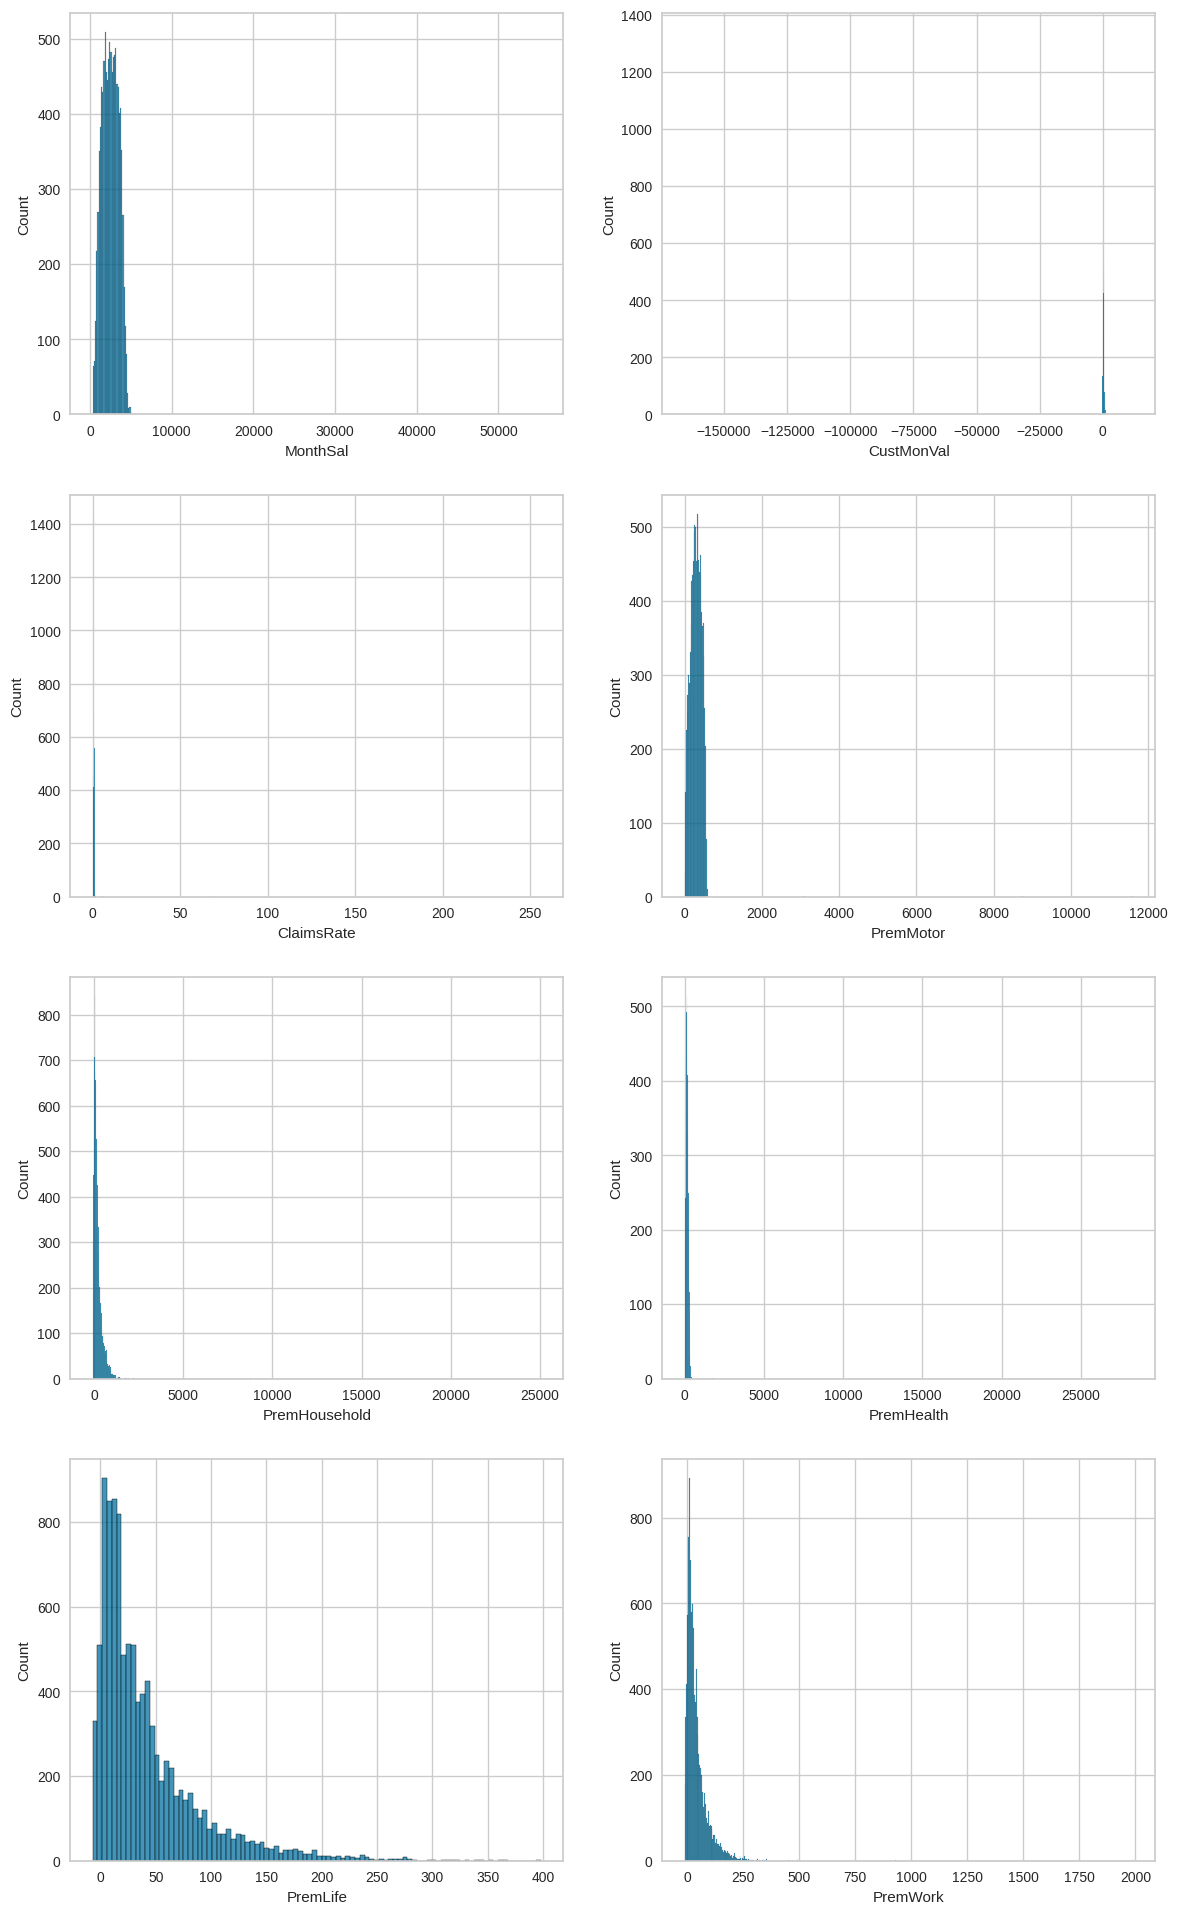

In [55]:
clmns = ['MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']
fig, ax = plt.subplots((len(clmns)+1)//2, 2, figsize=(14, len(clmns)*3))

for i, clmn in enumerate(clmns):
    sns.histplot(df[clmn], ax=ax[i//2][i%2])

 - Outliers need to be removed

In [15]:
num_clmns = ['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']
cat_clmns = ['EducDeg', 'GeoLivArea', 'Children']

In [ ]:
fig, ax = plt.subplots(len(num_clmns), 1, figsize=(20,20))

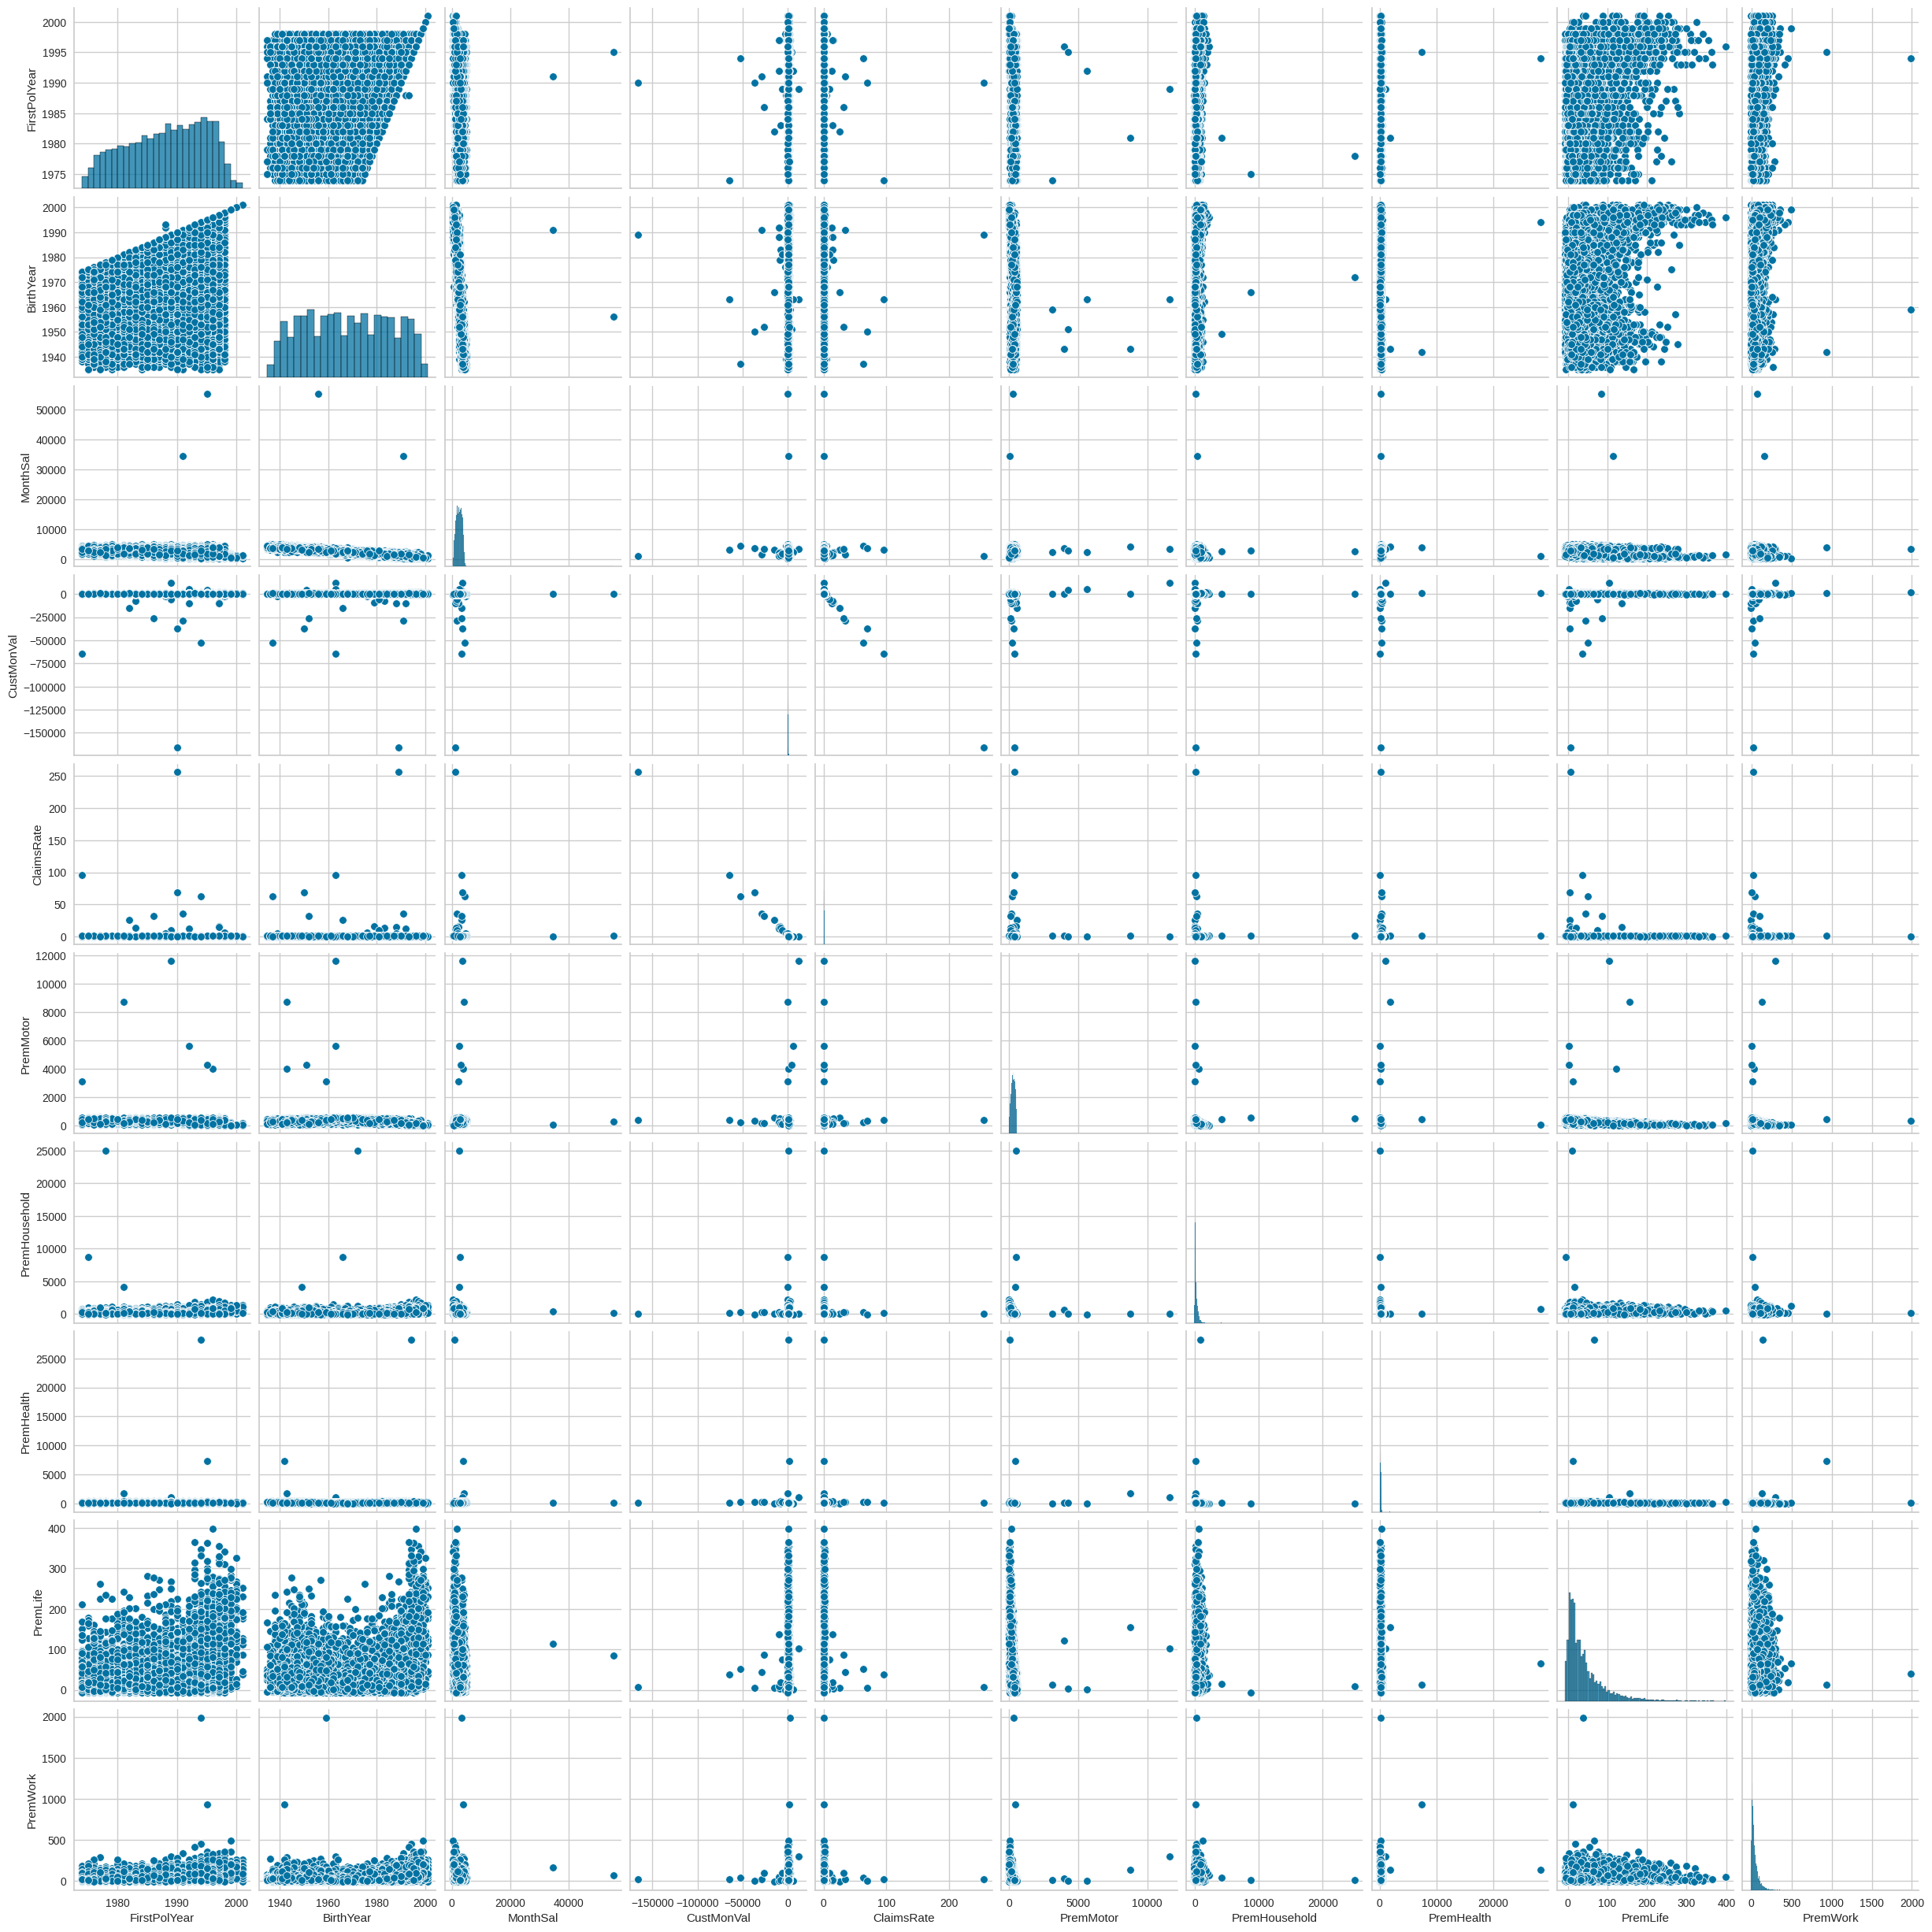

In [14]:
sns.pairplot(df[num_clmns]);

In [33]:
df["Total_Premiums"] = df["PremMotor"] + df["PremHousehold"] + df["PremHealth"] + df ["PremLife"] + df["PremWork"]

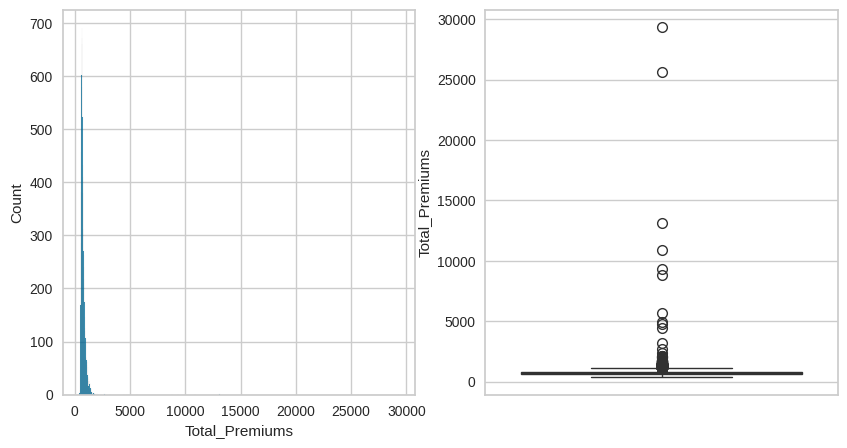

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(df['Total_Premiums'], ax=ax[0]);
sns.boxplot(df['Total_Premiums'], ax=ax[1]);

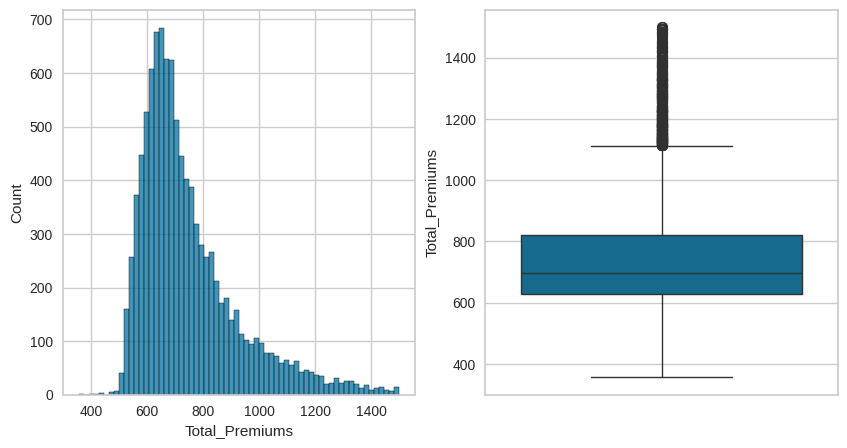

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(df[df['Total_Premiums']<1500]['Total_Premiums'], ax=ax[0]);
sns.boxplot(df[df['Total_Premiums']<1500]['Total_Premiums'], ax=ax[1]);

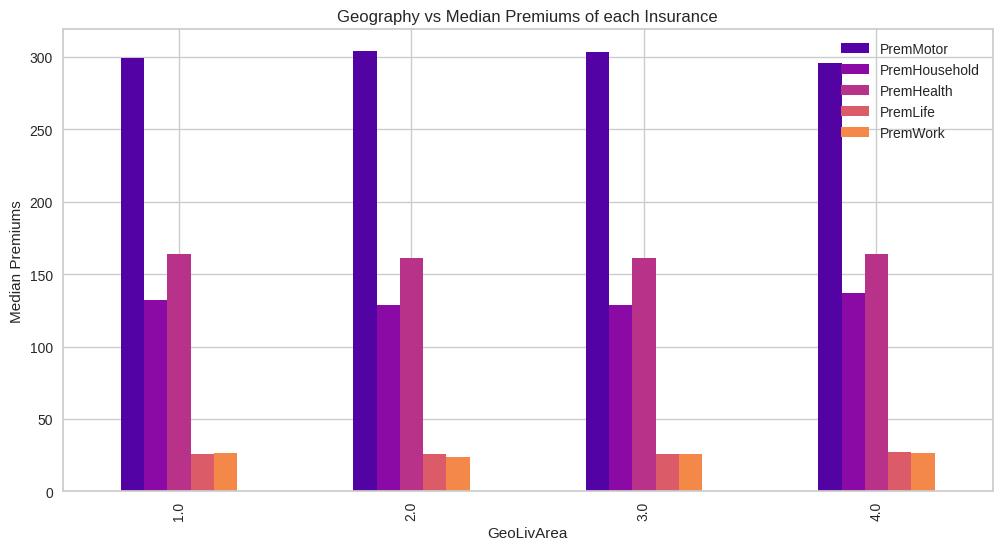

In [50]:
Premiums = ['PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']
# colors = ['green', 'lightgreen', 'blue', 'lightblue', 'red']
colors = sns.color_palette("plasma")
df.groupby('GeoLivArea')[Premiums].median().plot.bar(stacked=False, color=colors, figsize=(12,6))
plt.ylabel('Median Premiums')
plt.title("Geography vs Median Premiums of each Insurance");

In [34]:
prem_clmns = ['PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']

for clmn in prem_clmns:
    df[f"{clmn}_percent"] = round(df[clmn]*100 / df['Total_Premiums'], 2)

In [35]:
prem_percent_clmns = ['PremMotor_percent', 'PremHousehold_percent','PremHealth_percent', 'PremLife_percent', 'PremWork_percent']

<ipython-input-36-60bf50186b54>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
<ipython-input-36-60bf50186b54>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
<ipython-input-36-60bf50186b54>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
<ipython-input-36-60bf50186b54>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)


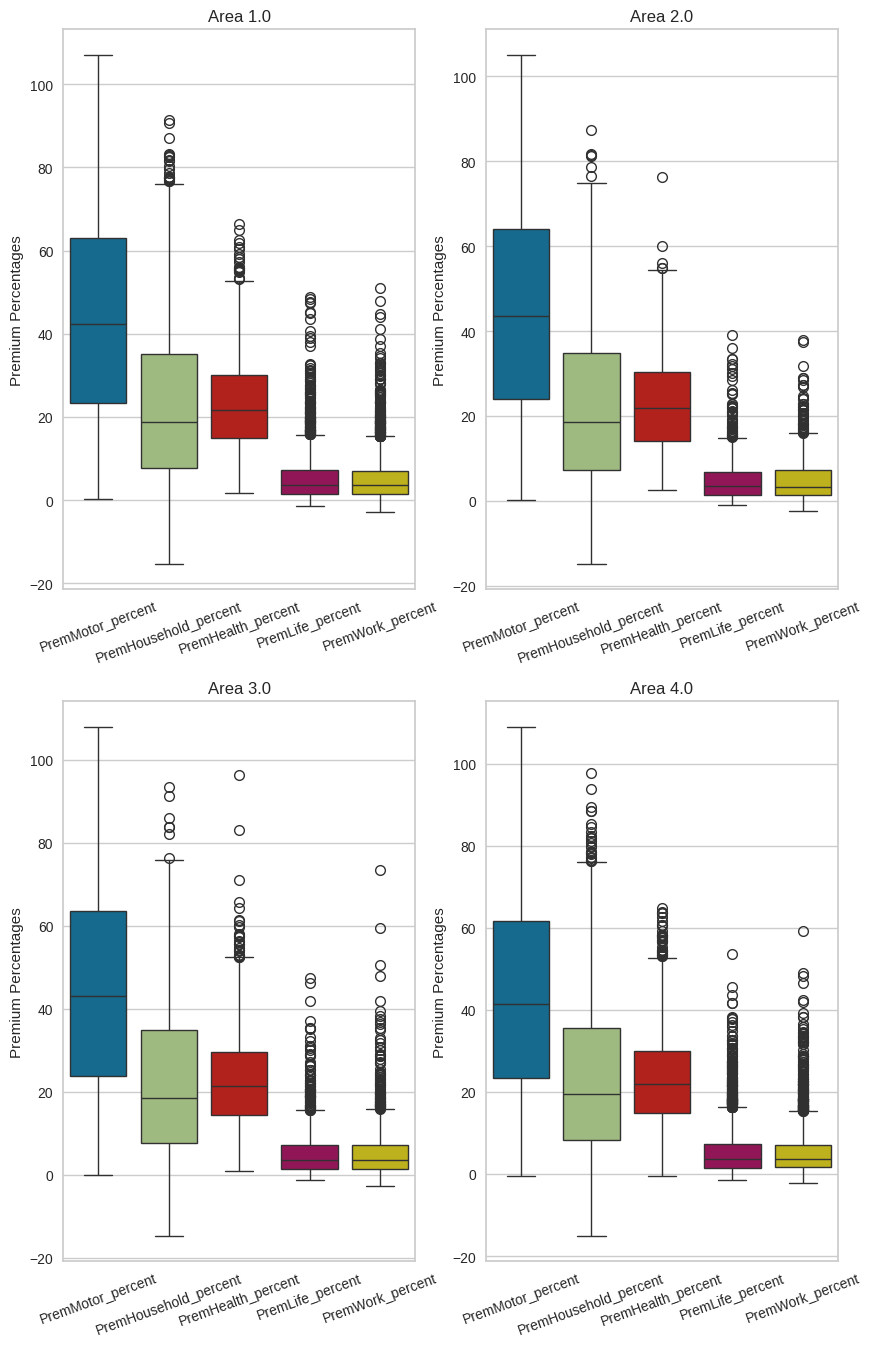

In [36]:
unique_areas = np.sort(df['GeoLivArea'].unique())

fig, ax = plt.subplots((len(unique_areas)+1)//2, 2, figsize=(10,len(unique_areas)*4))
for i, area in enumerate(unique_areas):
    area_df = df[df['GeoLivArea']==area][prem_percent_clmns]
    sns.boxplot(x="variable", y="value", hue='variable', data=pd.melt(area_df), ax=ax[i//2][i%2])
    ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
    ax[i//2][i%2].set(xlabel="", ylabel='Premium Percentages')
    ax[i//2][i%2].set_title(f"Area {area}");

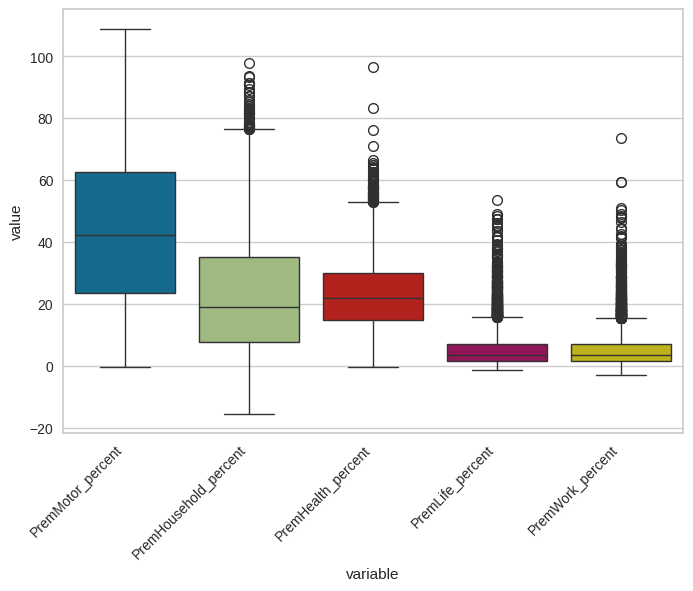

In [37]:
sns.boxplot(x="variable", y="value", hue='variable', data=pd.melt(df[prem_percent_clmns]));
plt.xticks(rotation=45, ha='right');

 - Geography doesnt contribute to percentage of premiums.

<ipython-input-103-2cddb4475c55>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=age_df, x='Age_Class', palette='husl', order=age_counts.index)


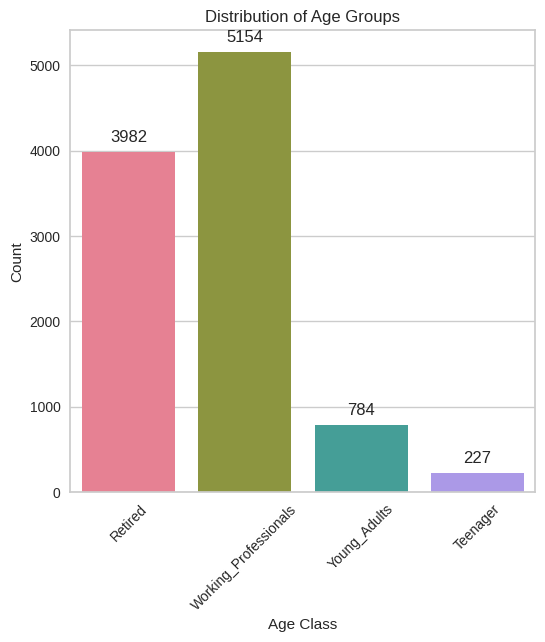

In [103]:
age_df = df.copy()
bins = [0, 20, 25, 55, float('inf')]
labels = ['Teenager', 'Young_Adults', 'Working_Professionals', 'Retired']
age_df['Age_Class'] = pd.cut(age_df['Age'], bins=bins, labels=labels, right=False)
age_counts = age_df['Age_Class'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=age_df, x='Age_Class', palette='husl', order=age_counts.index)
for i, count in enumerate(age_counts):
    ax.annotate(f'{count}', (i, count), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
plt.xlabel("Age Class")
plt.ylabel("Count")
plt.title("Distribution of Age Groups")
plt.xticks(rotation=45)
plt.show();

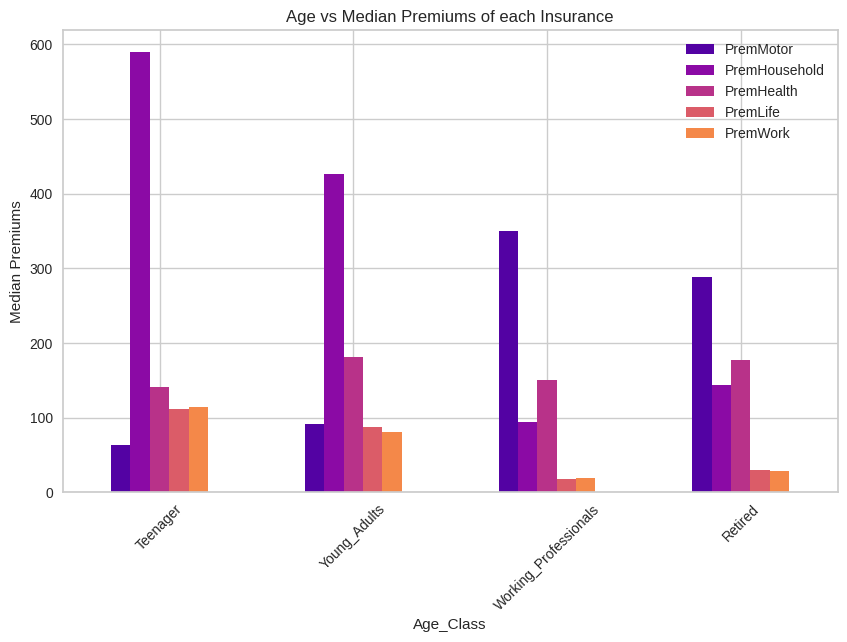

In [107]:
colors = sns.color_palette("plasma")
age_df.groupby('Age_Class')[Premiums].median().plot.bar(stacked=False, color=colors, figsize=(10,6))
plt.ylabel('Median Premiums')
plt.xticks(rotation=45)
plt.title("Age vs Median Premiums of each Insurance");

 -

<ipython-input-38-905274119e9c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)
<ipython-input-38-905274119e9c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)


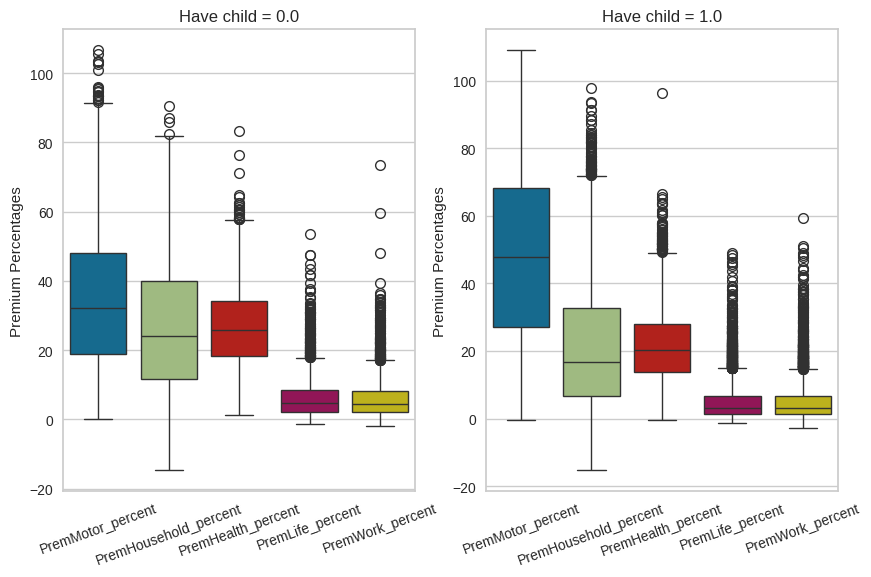

In [38]:
unique_children = np.sort(df['Children'].unique())

fig, ax = plt.subplots(1, 2, figsize=(10,6))
for i, child in enumerate(unique_children):
    child_df = df[df['Children']==child][prem_percent_clmns]
    sns.boxplot(x="variable", y="value", hue='variable', data=pd.melt(child_df), ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)
    ax[i].set(xlabel="", ylabel='Premium Percentages')
    ax[i].set_title(f"Have child = {child}");


 - Customers with children contribute greater portion of their total premiums for Vechicle premiums compared to those with no children.

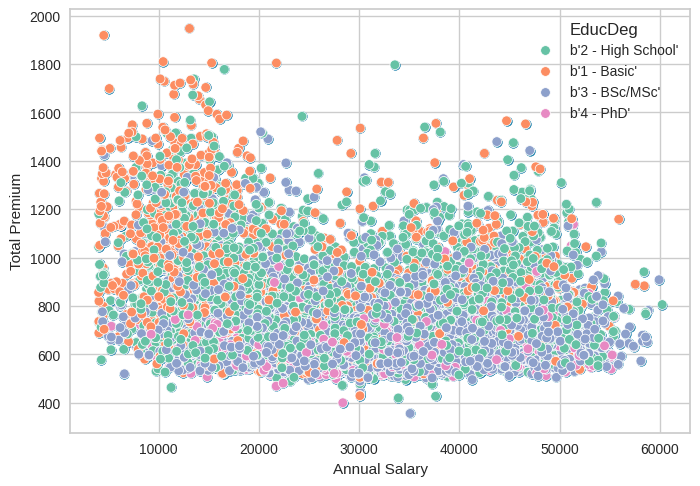

In [42]:
tmp_df = df[(df['MonthSal']*12 < 100000) & (df['Total_Premiums'] < 2000)].copy()
tmp_df['AnnualSal'] = df['MonthSal']*12
plt.scatter(tmp_df['AnnualSal'], tmp_df['Total_Premiums'])
sns.scatterplot(tmp_df, x='AnnualSal', y='Total_Premiums', hue='EducDeg', palette='Set2');
plt.xlabel('Annual Salary')
plt.ylabel('Total Premium');

 - total premium & annual salary have no correlation.

<ipython-input-43-62262b548406>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
<ipython-input-43-62262b548406>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
<ipython-input-43-62262b548406>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
<ipython-input-43-62262b548406>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)


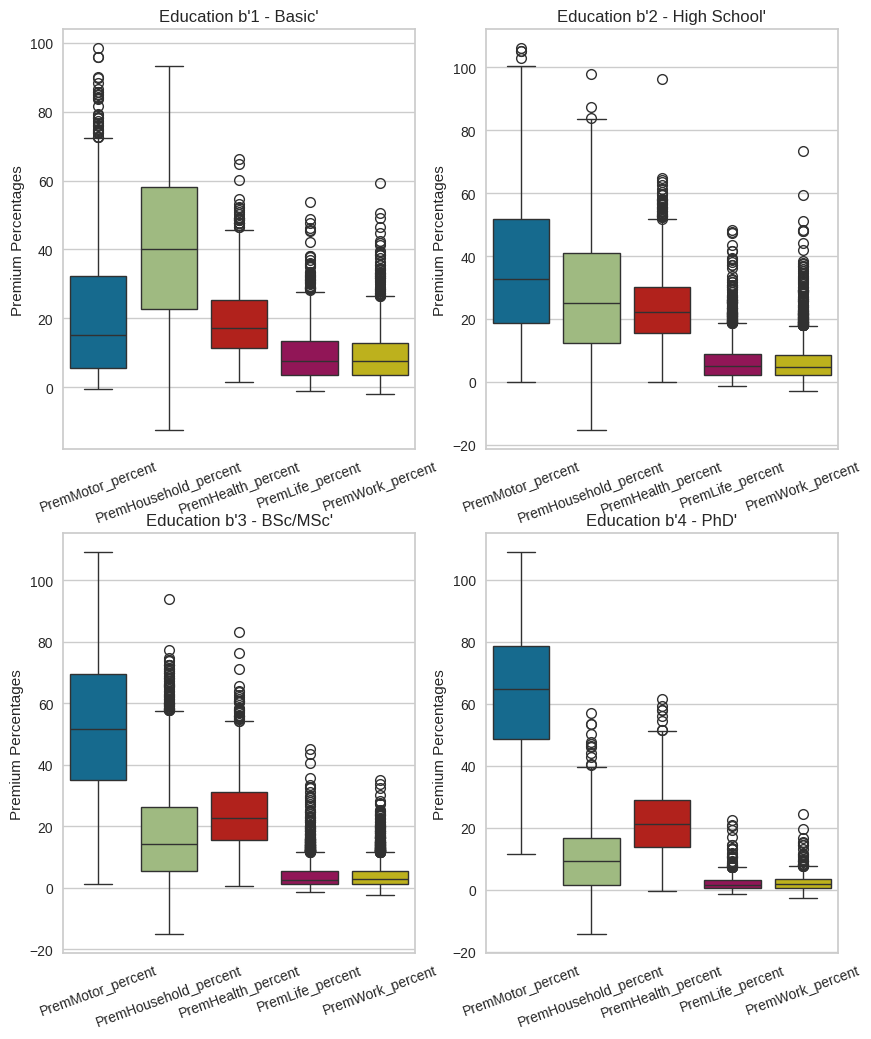

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(10,12))
for i, educ in enumerate(np.sort(df['EducDeg'].unique())):
    educ_df = df[df['EducDeg']==educ][prem_percent_clmns]
    sns.boxplot(x="variable", y="value", hue='variable', data=pd.melt(educ_df), ax=ax[i//2][i%2])
    ax[i//2][i%2].set_xticklabels(ax[i//2][i%2].get_xticklabels(),rotation=20)
    ax[i//2][i%2].set(xlabel="", ylabel='Premium Percentages')
    ax[i//2][i%2].set_title(f"Education {educ}");

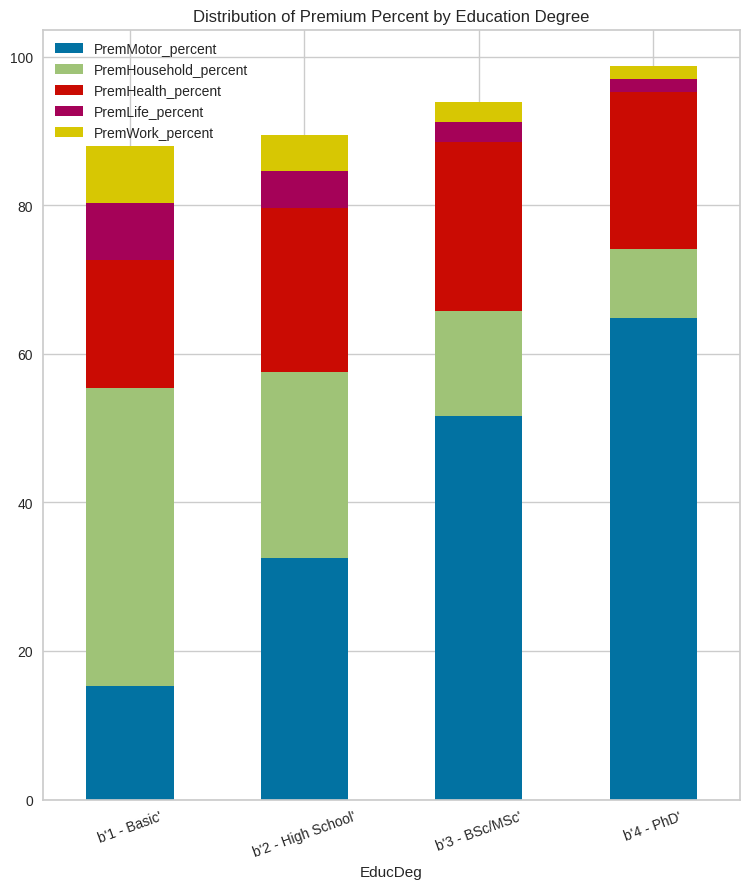

In [67]:
# plt.figure(figsize=(12,12))
fig, ax = plt.subplots(1,1, figsize=(9,10))
df.groupby('EducDeg')[prem_percent_clmns].median().plot(kind='bar', stacked=True, title='Distribution of Premium Percent by Education Degree', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)
plt.legend(loc='upper left')
plt.show();

- Customers with basic education contribute most of their premiums for Household premiums.

<ipython-input-49-a10cc1ef76bf>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[df_processed.columns].corr(), annot=True,fmt= '.2f');


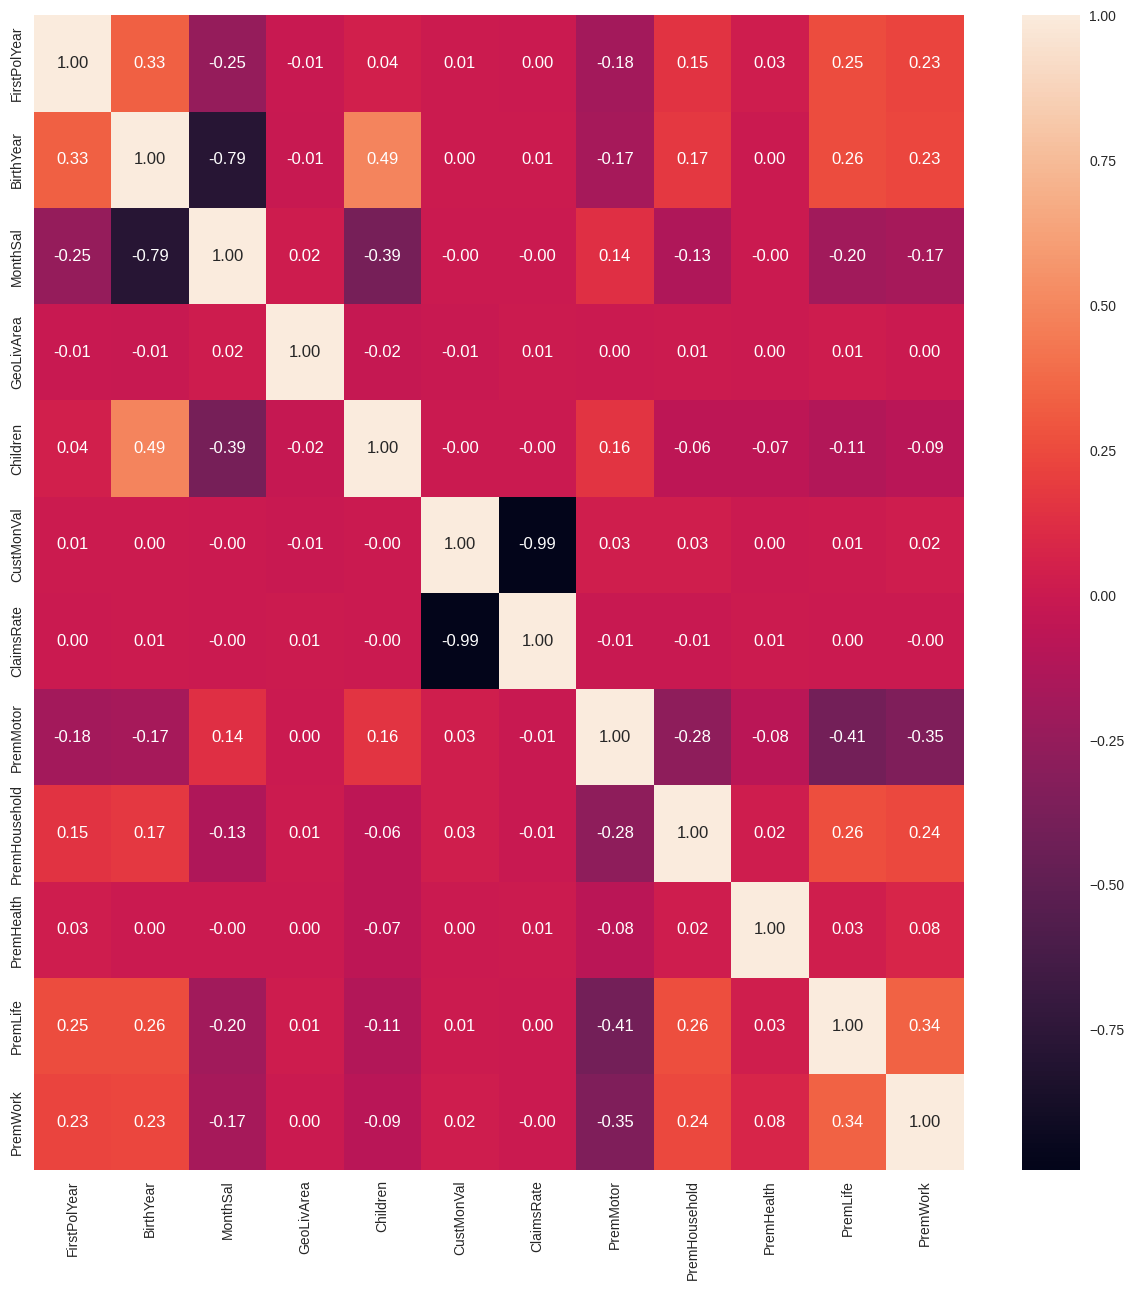

In [49]:
plt.figure(figsize=(15,15))
sns.heatmap(df[df_processed.columns].corr(), annot=True,fmt= '.2f');

# Feature Engineering

In [70]:
df = df_processed.copy()

In [71]:
df['Age'] = 2016 - df['BirthYear']

In [72]:
df['Annual_Salary'] = df['MonthSal'] * 12

In [73]:
df["Total_Premiums"] = df["PremMotor"] + df["PremHousehold"] + df["PremHealth"] + df ["PremLife"] + df["PremWork"]

In [74]:
df["Commitment"] = df["Annual_Salary"] / df["Total_Premiums"]

In [75]:
df.drop(df[df["Age"] < 18].index, axis=0, inplace=True)

In [76]:
df.drop(['BirthYear'], axis=1, inplace=True)

## Outlier Removal

### IQR Outlier

In [69]:
def IQR_method(data, clmns):

    q25 = data[clmns].quantile(.25)
    q75 = data[clmns].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 1.5 * iqr
    lower_lim = q25 - 1.5 * iqr

    filter = []
    for clmn in clmns:
        llim = lower_lim[clmn]
        ulim = upper_lim[clmn]
        filter.append(data[clmn].between(llim, ulim, inclusive = 'both'))
    filter = pd.Series(np.all(filter, 0), index = data.index)

    filtered_data = data[filter]

    return filtered_data

In [80]:
non_metric_features = ['EducDeg', 'GeoLivArea', 'Children']
metric_features = [clmn for clmn in df.columns if clmn not in non_metric_features]

In [117]:
metric_features

['FirstPolYear',
 'MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Age',
 'Annual_Salary',
 'Total_Premiums',
 'Commitment']

In [81]:
df_iqr = IQR_method(df, metric_features)

In [86]:
len(df), len(df_iqr), len(df_iqr)*100/len(df)

(10176, 8714, 85.63286163522012)

### Manual Outlier

In [83]:
# These limits are obtained from histograms of corresponding features.
outlier_filter = (
    (df["FirstPolYear"] <= 2016)
    &
    (df["MonthSal"] <= 7000)
    &
    (df["CustMonVal"] <= 7000) & (-1000 <= df["CustMonVal"])
    &
    (df["ClaimsRate"] <= 100)
    &
    (df["PremMotor"] <= 2000)
    &
    (df["PremHousehold"] <= 2000)
    &
    (df["PremHealth"] <= 5000)
    &
    (df["PremLife"] <= 5000)
    &
    (df["PremWork"] <= 500)
    &
    (df["Commitment"] <= 250)
)

In [84]:
df_manual = df[outlier_filter]

In [87]:
len(df), len(df_manual), len(df_manual)*100/len(df)

(10176, 10147, 99.71501572327044)

IQR Method removes a lot of records that could be useful. Thus manual outliers filtering was performed.

In [92]:
df_pre_outlier = df.copy()

In [241]:
df = df_manual.copy()

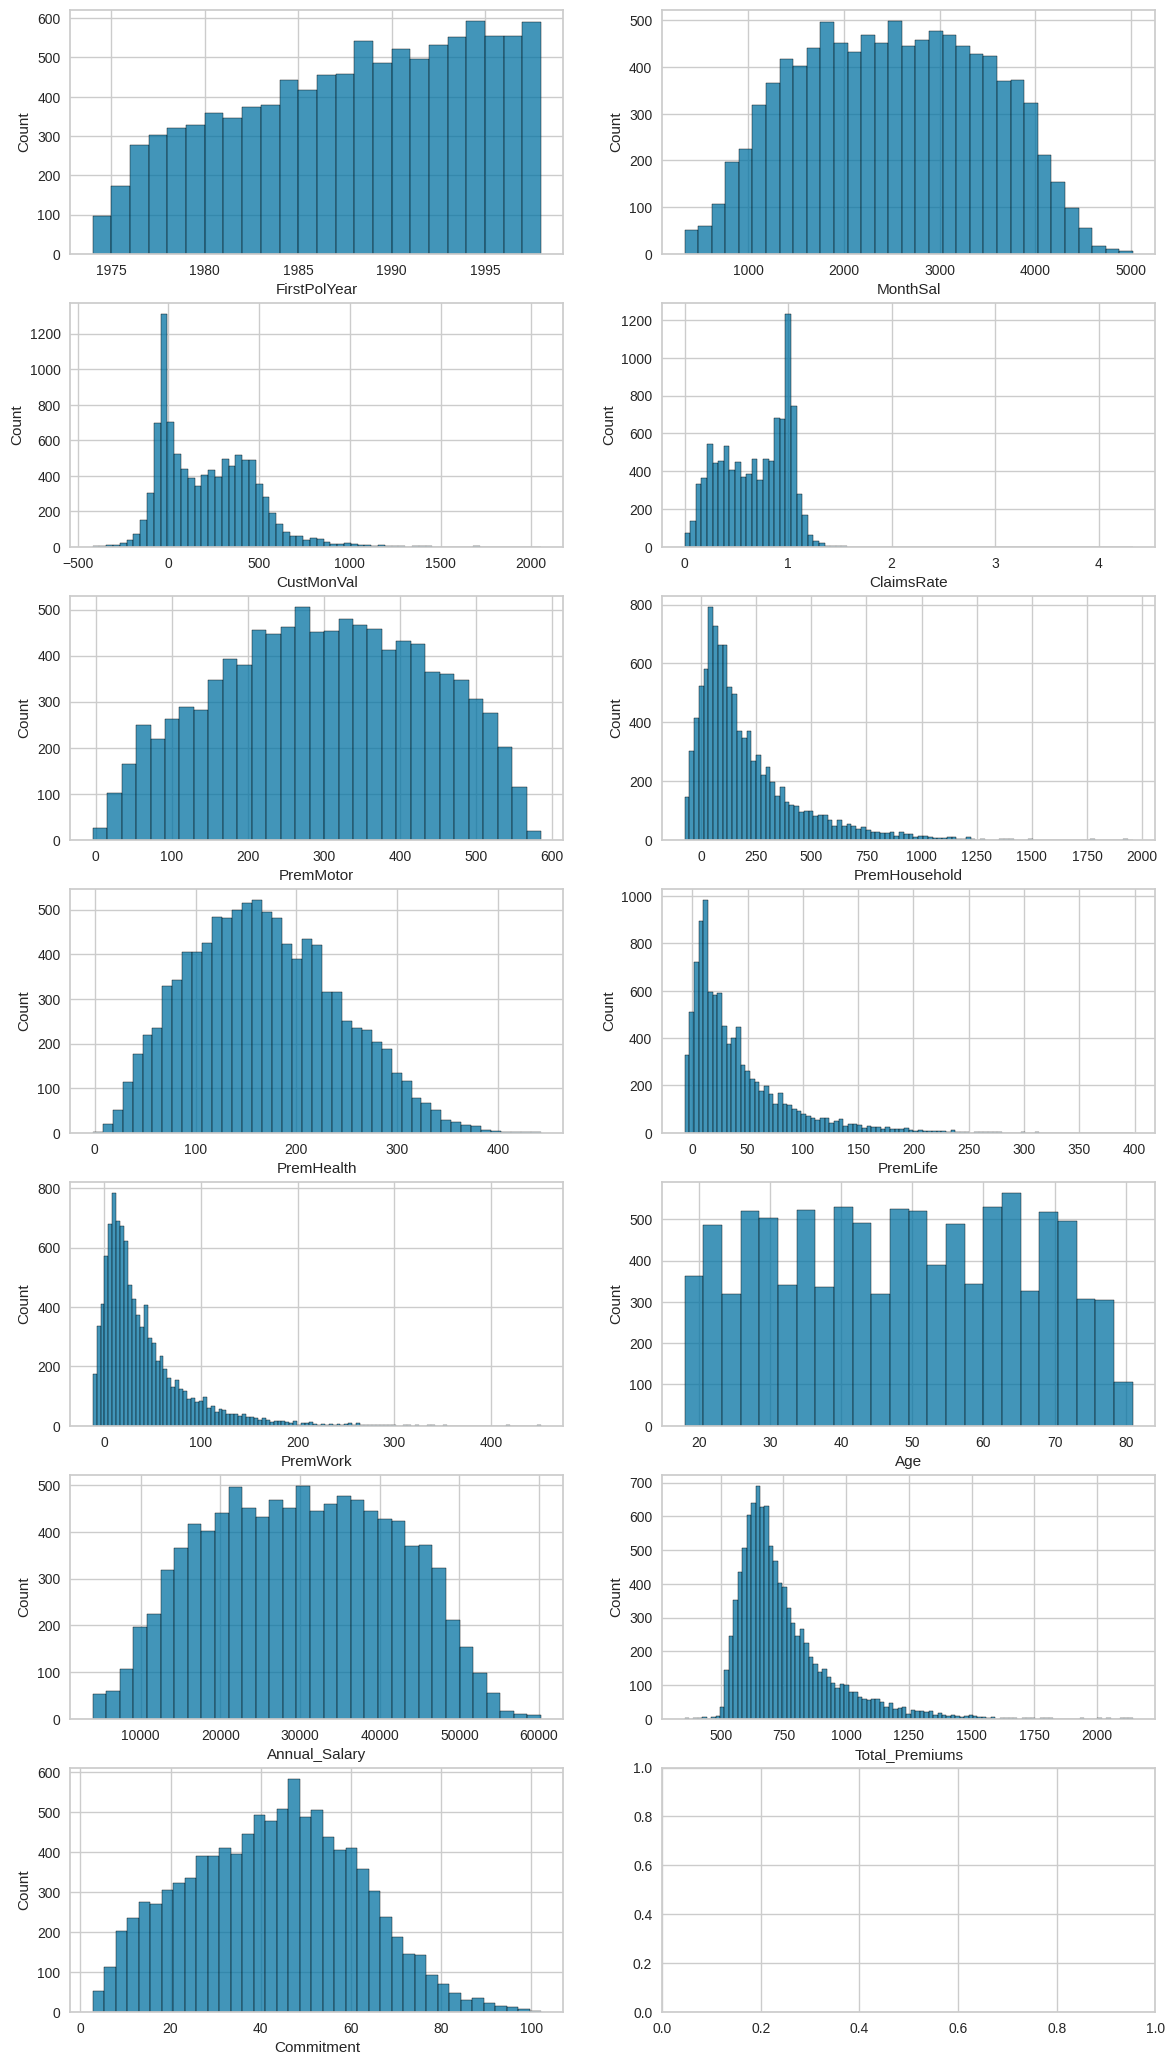

In [95]:
# clmns = ['FirstPolYear', 'BirthYear', 'EducDeg', 'GeoLivArea', 'Children']
fig, ax = plt.subplots((len(metric_features)+1)//2, 2, figsize=(14, len(metric_features)*2))

for i, clmn in enumerate(metric_features):
    sns.histplot(df[clmn], ax=ax[i//2][i%2])

## Binning

In [242]:
binsInterval = [0, 12000, 24000, 36000, 48000, 60000, 720000]
intervalLabels = ['(0, 12000]', '(12000, 24000]',  '(24000, 36000]', '(36000, 48000]', '(48000, 60000]', '(>60000]']
df['AnnualSal_binned'] = pd.cut(df['Annual_Salary'], bins = binsInterval, labels=intervalLabels)

df['EducDeg'] = df['EducDeg'].apply(lambda x: int(x[2]))

cols = ['AnnualSal_binned']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
df = ce_one_hot.fit_transform(df)

In [97]:
df.head()

FirstPolYear  EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  \
0        1985.0        2    2177.0         1.0       1.0      380.97   
1        1995.0        2     677.0         4.0       1.0     -131.13   
2        1991.0        1    2277.0         3.0       0.0      504.67   
3        1990.0        3    1099.0         4.0       1.0      -16.99   
4        1986.0        3    1763.0         4.0       1.0       35.23   

   ClaimsRate  PremMotor  PremHousehold  PremHealth  ...   Age  Annual_Salary  \
0        0.39     375.85          79.45      146.36  ...  34.0        26124.0   
1        1.12      77.46         416.20      116.69  ...  21.0         8124.0   
2        0.28     206.15         224.50      124.58  ...  46.0        27324.0   
3        0.99     182.48          43.35      311.17  ...  35.0        13188.0   
4        0.90     338.62          47.80      182.59  ...  43.0        21156.0   

   Total_Premiums  Commitment  AnnualSal_binned_(0, 12000]  \
0          665.56   39.251157                            0   
1          910.96    8.918064                            1   
2          740.60   36.894410                            0   
3          600.68   21.955118                            0   
4          629.24   33.621512                            0   

   AnnualSal_binned_(12000, 24000]  AnnualSal_binned_(24000, 36000]  \
0                                0                                1   
1                                0                                0   
2                                0                                1   
3                                1                                0   
4                                1                                0   

   AnnualSal_binned_(36000, 48000]  AnnualSal_binned_(48000, 60000]  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   AnnualSal_binned_(>60000]  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  

[5 rows x 22 columns]

## Scaling

### MinMax Scaling

In [243]:
df_minmax = pd.DataFrame(MinMaxScaler().fit_transform(df.values), columns=df.columns, index=df.index).drop(['MonthSal', 'Annual_Salary'], axis=1)

### Standard Scaling

In [110]:
df_stdscal = pd.DataFrame(StandardScaler().fit_transform(df.values), columns=df.columns, index=df.index).drop(['MonthSal', 'Annual_Salary'], axis=1)

In [108]:
df_minmax.columns

Index(['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Total_Premiums', 'Commitment',
       'AnnualSal_binned_(0, 12000]', 'AnnualSal_binned_(12000, 24000]',
       'AnnualSal_binned_(24000, 36000]', 'AnnualSal_binned_(36000, 48000]',
       'AnnualSal_binned_(48000, 60000]', 'AnnualSal_binned_(>60000]'],
      dtype='object')

# Clustering

In [153]:
def plot_silhouette_score(data, max_clusters, cluster_algo, title="", **kwargs):
    sil = []
    print(kwargs)
    for k in range(2, max_clusters):
        cluster = cluster_algo(k, **kwargs)
        labels = cluster.fit_predict(data)
        sil.append(silhouette_score(data, labels, metric = 'euclidean'))

    fig , ax = plt.subplots(figsize=(5, 4))
    plt.plot(range(2, max_clusters), sil, 'bx-')
    sns.despine()
    fmt = "{x:,.2f}"
    tick = ticker.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette score');
    plt.title(title)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    return sil

## KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

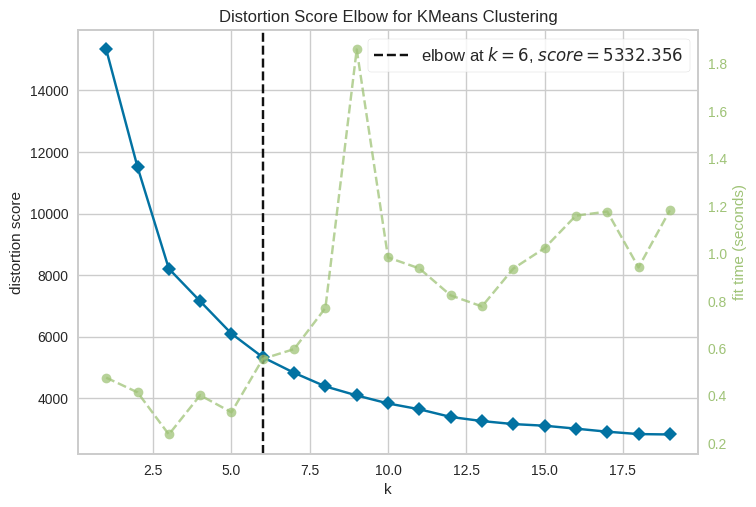

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [113]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=5)
visualizer.fit(df_minmax)
visualizer.show()

{}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

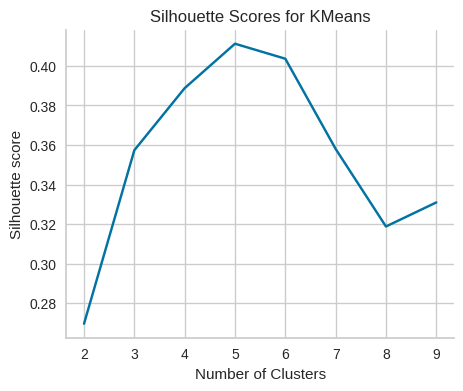

In [154]:
kmeans_sil = plot_silhouette_score(df_minmax, 10, KMeans, 'Silhouette Scores for KMeans')

In [279]:
km = KMeans(n_clusters = 6)
df['kmeans_6'] = km.fit_predict(df_minmax)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Agglomerative Clustering

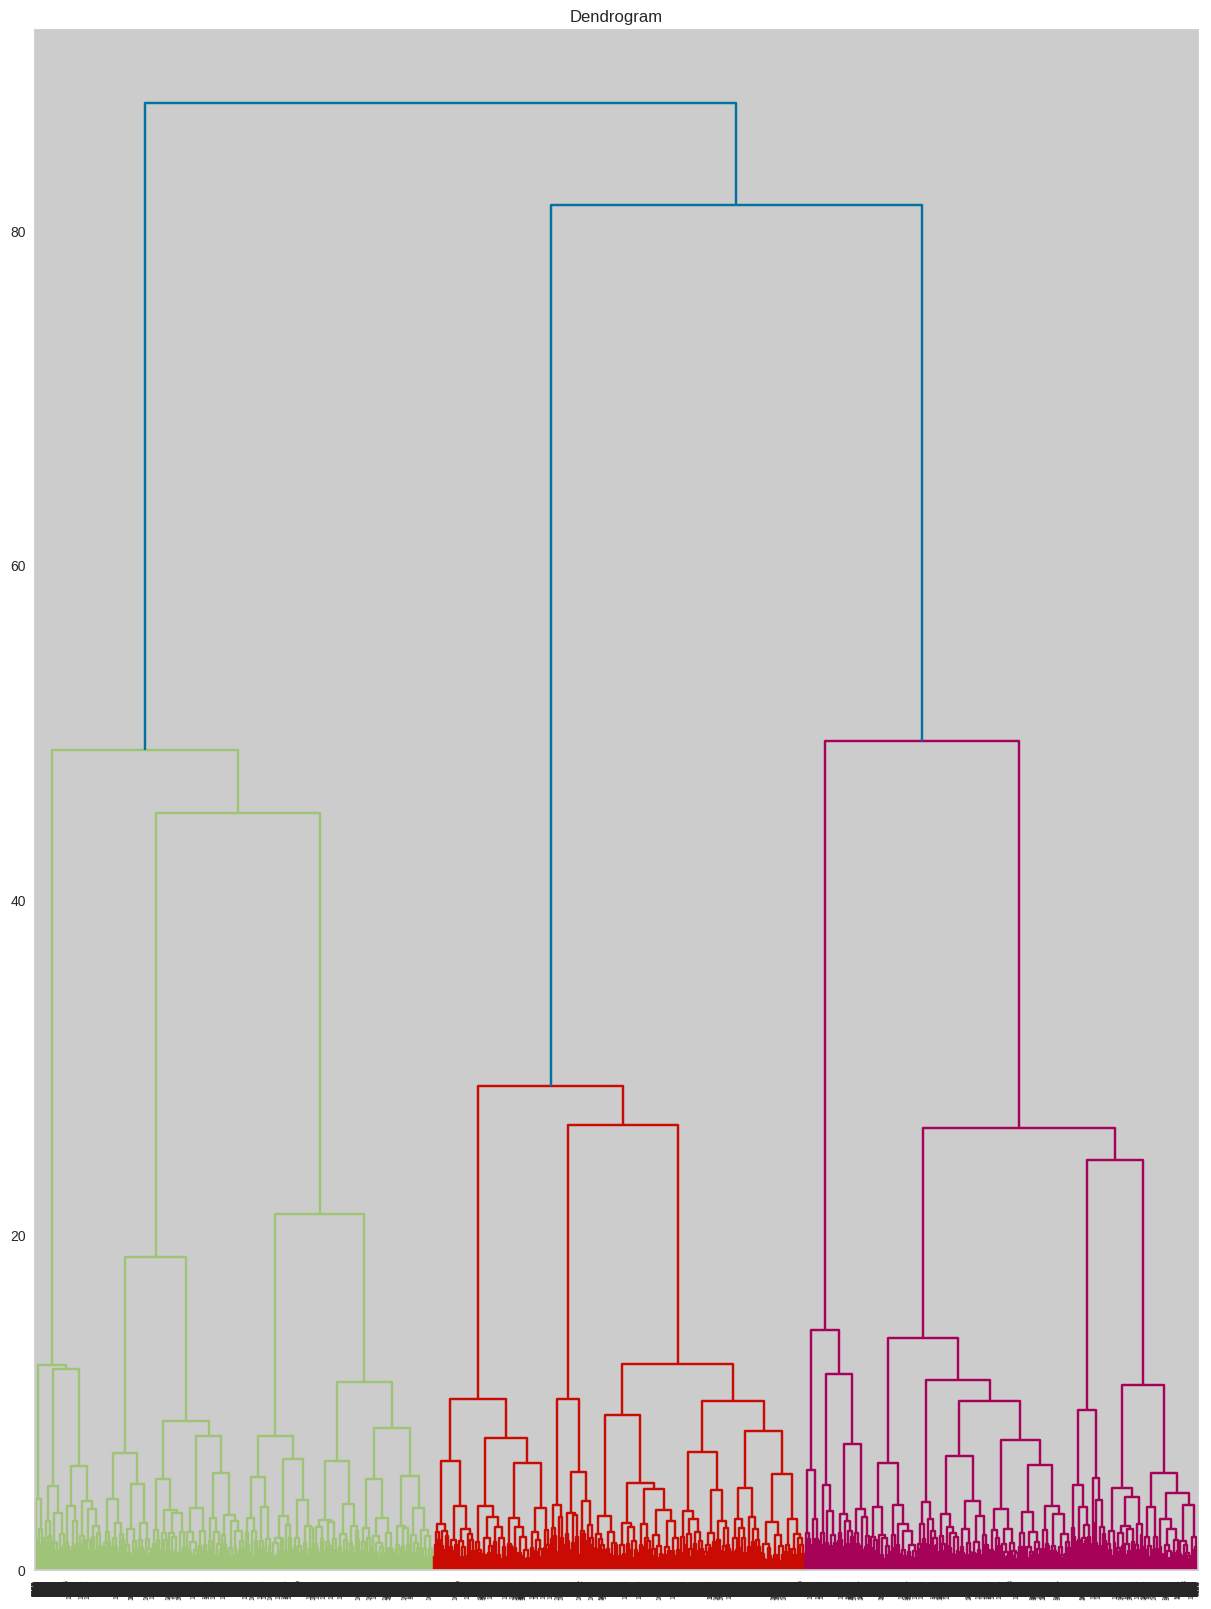

In [96]:
plt.figure(figsize=(15, 20))
plt.title("Dendrogram")
dend = sch.dendrogram(sch.linkage(df_minmax, method='ward'))

{}


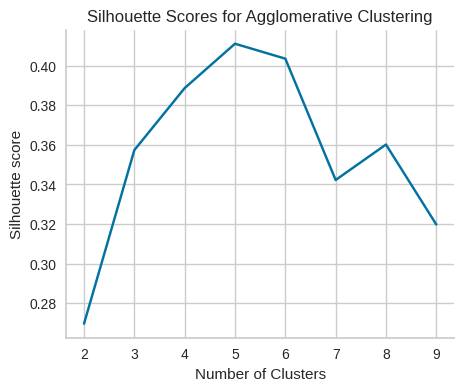

In [155]:
aglo_sil = plot_silhouette_score(df_minmax, 10, AgglomerativeClustering, 'Silhouette Scores for Agglomerative Clustering')

In [268]:
ac = AgglomerativeClustering(6)
ac_labels = ac.fit_predict(df_minmax)

## GMM

### MinMax

{}


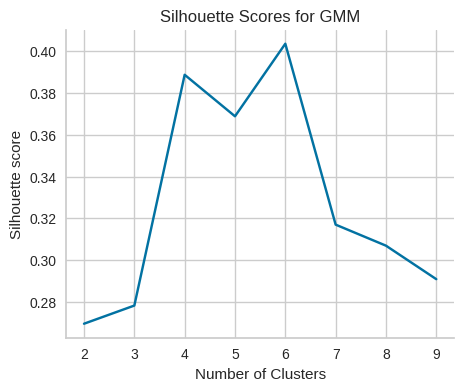

In [159]:
gmm_sil = plot_silhouette_score(df_minmax, 10, GaussianMixture, 'Silhouette Scores for GMM')

### Standard Scaling

{}


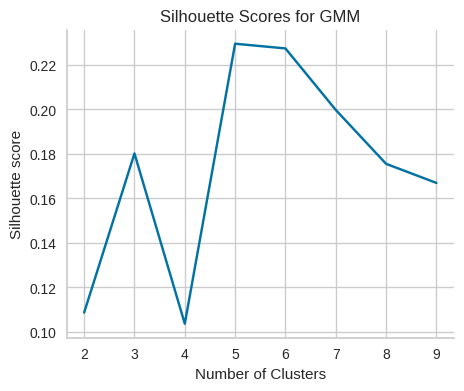

In [160]:
gmm_sil = plot_silhouette_score(df_stdscal, 10, GaussianMixture, 'Silhouette Scores for GMM')

## DBSCAN

In [263]:
def plot_dbscan_distance_plot(dataset):
    min_samples = 2*dataset.shape[1]
    neighbors = NearestNeighbors(n_neighbors=20)
    neighbors_fit = neighbors.fit(dataset)
    distances, indices = neighbors_fit.kneighbors(dataset)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    return min_samples

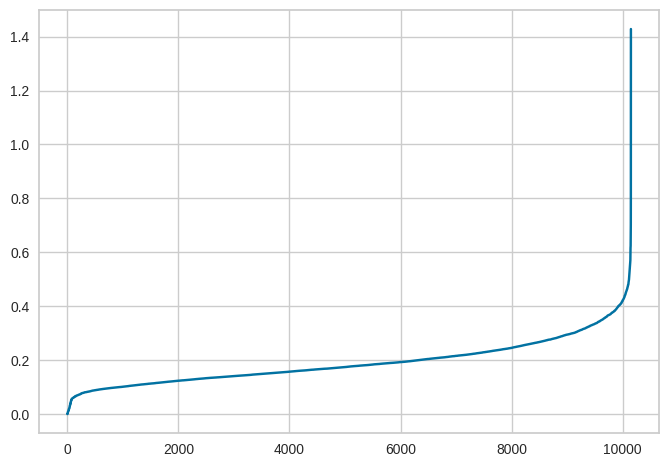

In [264]:
min_samples = plot_dbscan_distance_plot(df_minmax)

In [265]:
dbscan_model = DBSCAN(eps=0.45, min_samples=min_samples).fit(df_minmax)
labels = dbscan_model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 1199


In [266]:
print(f"Silhouette Coefficient: {silhouette_score(df_minmax, labels):.3f}")

Silhouette Coefficient: 0.300


## GridSearch

In [122]:

param_grid = {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'init': ['k-means++', 'random'],
              'max_iter': [100, 250, 500, 750, 1000]}

# Create a KMeans instance
kmeans = KMeans()

#Creating the GridSearchCV object
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5, scoring = normalized_mutual_info_score)

#Fitting the GridSearchCV object to the data
grid_search.fit(df_minmax)

#Printting the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py", line 1037, in normalized_mutual_info_score
    labels_true, labels_pred = check_clusterings(labels_true, labels_pred)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py", line 68, in check_clusterings
    

Best parameters:  {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2}
Best score:  nan


{'init': 'k-means++', 'max_iter': 1000}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

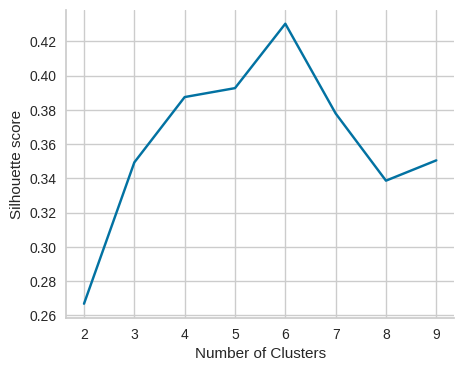

In [117]:
# km = KMeans(init = 'k-means++', max_iter = 250, n_clusters=10)
# visualizer = KElbowVisualizer(df_minmax, k=(1,20), random_state=5)
# visualizer.fit(first_minmax)

kmeans_sil = plot_silhouette_score(df_minmax, 10, KMeans, init= 'k-means++', max_iter= 1000)

## Clustering Age Wise

In [244]:
df_age = df_manual.copy()
df_age['EducDeg'] = df_age['EducDeg'].apply(lambda x: int(x[2]))

In [245]:
bins = [0, 20, 25, 55, float('inf')]
labels = ['Teenager', 'Young_Adults', 'Working_Professionals', 'Retired']
df_age['Age'] = pd.cut(df_age['Age'], bins=bins, labels=labels, right=False)

In [246]:
df_teen = df_age[df_age['Age']=='Teenager'].drop('Age',axis=1)
df_young = df_age[df_age['Age']=='Young_Adults'].drop('Age',axis=1)
df_working = df_age[df_age['Age']=='Working_Professionals'].drop('Age',axis=1)
df_retired = df_age[df_age['Age']=='Retired'].drop('Age',axis=1)

In [247]:
df_minmax1 = pd.DataFrame(MinMaxScaler().fit_transform(df_teen.values), columns=df_teen.columns, index=df_teen.index).drop(['MonthSal', 'Annual_Salary'], axis=1)
df_minmax2 = pd.DataFrame(MinMaxScaler().fit_transform(df_young.values), columns=df_young.columns, index=df_young.index).drop(['MonthSal', 'Annual_Salary'], axis=1)
df_minmax3 = pd.DataFrame(MinMaxScaler().fit_transform(df_working.values), columns=df_working.columns, index=df_working.index).drop(['MonthSal', 'Annual_Salary'], axis=1)
df_minmax4 = pd.DataFrame(MinMaxScaler().fit_transform(df_retired.values), columns=df_retired.columns, index=df_retired.index).drop(['MonthSal', 'Annual_Salary'], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

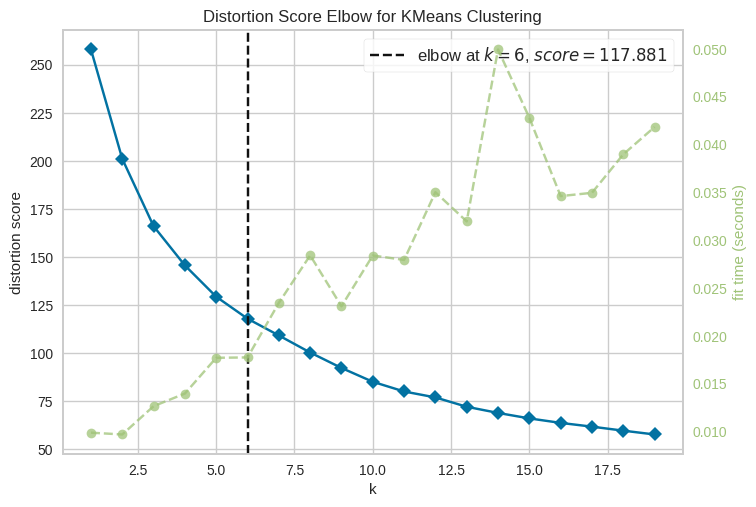

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [248]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=5)
visualizer.fit(df_minmax1)
visualizer.show()

{}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

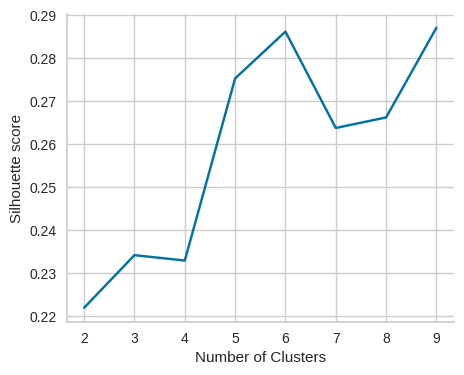

In [249]:
kmeans_sil1 = plot_silhouette_score(df_minmax1, 10, KMeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

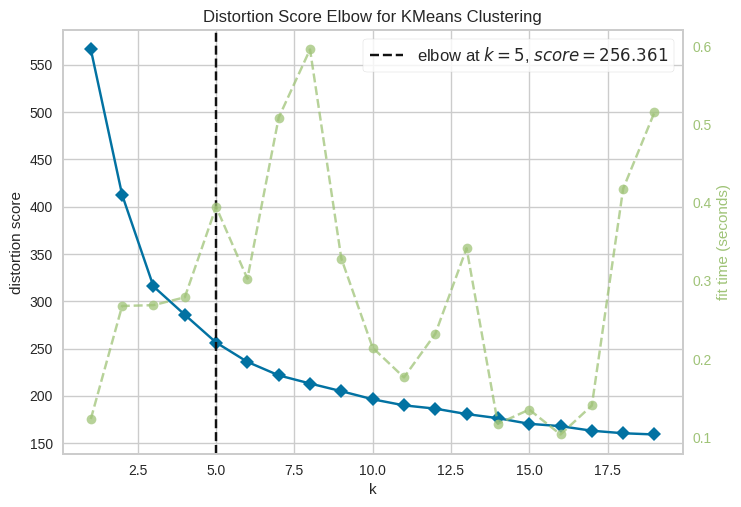

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [250]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=5)
visualizer.fit(df_minmax2)
visualizer.show()

{}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

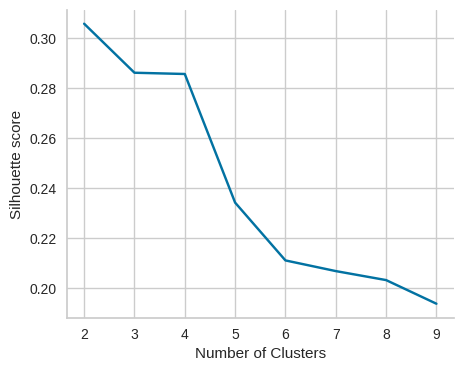

In [251]:
kmeans_sil2 = plot_silhouette_score(df_minmax2, 10, KMeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

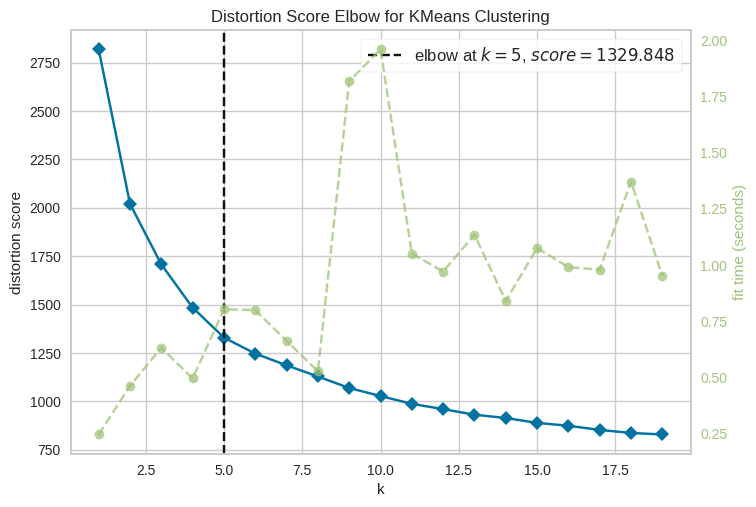

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [252]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=5)
visualizer.fit(df_minmax3)
visualizer.show()

{}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

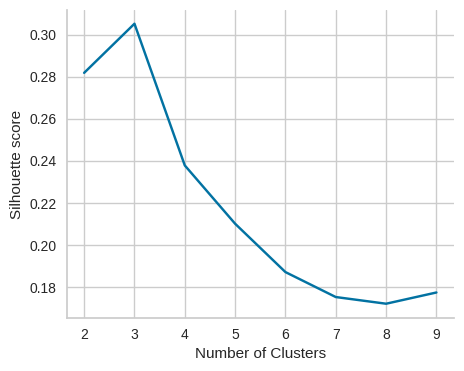

In [253]:
kmeans_sil3 = plot_silhouette_score(df_minmax3, 10, KMeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

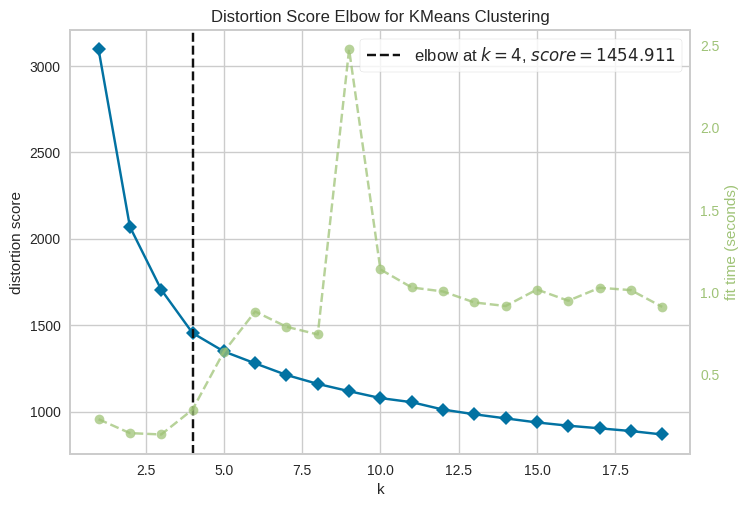

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [254]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=5)
visualizer.fit(df_minmax4)
visualizer.show()

{}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

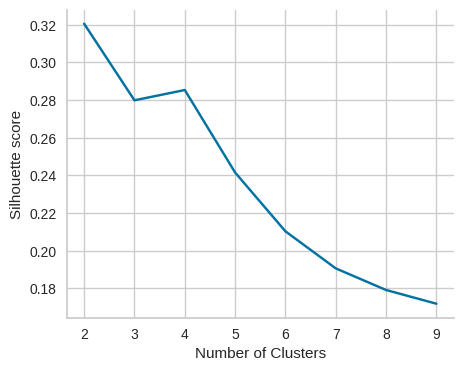

In [255]:
kmeans_sil4 = plot_silhouette_score(df_minmax4, 10, KMeans)

In [259]:
km = KMeans(n_clusters = 3)
df_teen['kmeans_3'] = km.fit_predict(df_minmax1)
df_teen.groupby('kmeans_3')[df_minmax1.columns].median().T

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_3                  0            1            2
FirstPolYear    1997.000000  1998.000000  1997.000000
EducDeg            2.000000     1.000000     1.000000
GeoLivArea         3.000000     3.000000     3.000000
Children           1.000000     1.000000     1.000000
CustMonVal       186.040000   140.700000   191.260000
ClaimsRate         0.750000     0.790000     0.770000
PremMotor         91.350000    59.010000    56.900000
PremHousehold    559.000000   619.000000   624.550000
PremHealth       162.920000   121.800000   132.580000
PremLife         104.130000   106.020000   124.690000
PremWork          95.130000   121.690000   129.360000
Total_Premiums  1031.320000  1082.320000  1096.880000
Commitment        12.416671     9.879671     9.349708

In [260]:
km = KMeans(n_clusters = 4)
df_young['kmeans_4'] = km.fit_predict(df_minmax2)
df_young.groupby('kmeans_4')[df_minmax2.columns].median().T

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_4                  0            1            2            3
FirstPolYear    1995.000000  1994.000000  1994.000000  1994.000000
EducDeg            2.000000     2.000000     2.000000     2.000000
GeoLivArea         4.000000     1.000000     4.000000     1.000000
Children           0.000000     1.000000     1.000000     0.000000
CustMonVal       161.535000   207.820000   174.260000   252.160000
ClaimsRate         0.805000     0.700000     0.760000     0.660000
PremMotor         87.350000   103.240000    91.240000    67.345000
PremHousehold    483.150000   402.300000   411.200000   457.850000
PremHealth       161.530000   182.590000   185.590000   180.755000
PremLife         105.520000    79.570000    82.460000   105.020000
PremWork          92.685000    77.570000    74.570000   104.130000
Total_Premiums   982.960000   906.840000   915.400000   970.015000
Commitment        13.542445    14.687948    14.514869    13.664073

In [261]:
km = KMeans(n_clusters = 4)
df_working['kmeans_4'] = km.fit_predict(df_minmax3)
df_working.groupby('kmeans_4')[df_minmax3.columns].median().T

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_4                  0            1            2            3
FirstPolYear    1987.000000  1986.000000  1989.000000  1988.000000
EducDeg            3.000000     3.000000     2.000000     3.000000
GeoLivArea         1.000000     4.000000     4.000000     3.000000
Children           1.000000     1.000000     1.000000     0.000000
CustMonVal       180.975000   209.760000   180.140000   189.390000
ClaimsRate         0.720000     0.685000     0.740000     0.720000
PremMotor        363.235000   439.640000   231.820000   292.610000
PremHousehold     87.250000    52.800000   211.150000   165.600000
PremHealth       151.140000   108.130000   212.930000   141.250000
PremLife          16.780000     9.890000    41.120000    34.230000
PremWork          16.890000    10.890000    42.340000    30.560000
Total_Premiums   662.053473   634.010652   758.920000   719.130000
Commitment        37.171352    42.923339    26.659107    33.861945

In [262]:
km = KMeans(n_clusters = 4)
df_retired['kmeans_4'] = km.fit_predict(df_minmax4)
df_retired.groupby('kmeans_4')[df_minmax4.columns].median().T

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_4                  0            1            2            3
FirstPolYear    1986.000000  1986.000000  1986.000000  1987.000000
EducDeg            3.000000     3.000000     3.000000     3.000000
GeoLivArea         4.000000     1.000000     4.000000     1.000000
Children           0.000000     1.000000     1.000000     0.000000
CustMonVal       182.930000   180.595000   206.500000   191.040000
ClaimsRate         0.730000     0.715000     0.710000     0.710000
PremMotor        244.325000   353.400000   348.400000   247.270000
PremHousehold    157.800000   122.525000   123.900000   161.150000
PremHealth       208.650000   139.470000   139.360000   210.040000
PremLife          32.450000    24.670000    23.670000    34.340000
PremWork          31.560000    23.725000    24.670000    29.670000
Total_Premiums   718.860000   691.465000   694.240000   722.800000
Commitment        60.244744    54.670735    53.166339    59.863204

## Socio Demographic

In [229]:
socio_demo = ['EducDeg', 'GeoLivArea', 'Children', 'Age', 'ClaimsRate', 'Commitment',
              'AnnualSal_binned_(12000, 24000]', 'AnnualSal_binned_(24000, 36000]',
              'AnnualSal_binned_(36000, 48000]', 'AnnualSal_binned_(48000, 60000]', 'AnnualSal_binned_(>60000]']

In [230]:
df_socio_demo = df[socio_demo].copy()

In [231]:
df.columns

Index(['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment', 'AnnualSal_binned_(0, 12000]',
       'AnnualSal_binned_(12000, 24000]', 'AnnualSal_binned_(24000, 36000]',
       'AnnualSal_binned_(36000, 48000]', 'AnnualSal_binned_(48000, 60000]',
       'AnnualSal_binned_(>60000]', 'kmeans_6', 'claim_amount',
       'retention_cost', 'Profit_percent', 'Loss'],
      dtype='object')

In [232]:
df_socio_demo = pd.concat([df_socio_demo.drop(['GeoLivArea'],axis=1), pd.get_dummies(df_socio_demo['GeoLivArea'], prefix='GeoLivArea')], axis=1)

In [233]:
df_socio_demo_minmax = pd.DataFrame(MinMaxScaler().fit_transform(df_socio_demo.values), columns=df_socio_demo.columns, index=df_socio_demo.index)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

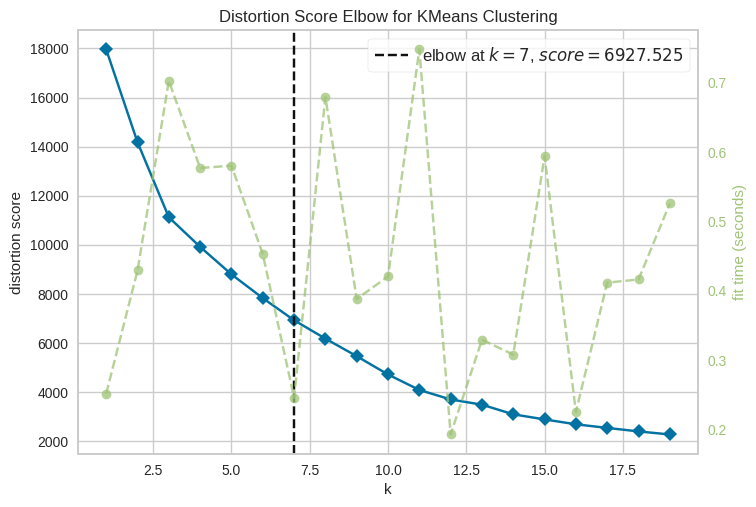

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [234]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=5)
visualizer.fit(df_socio_demo_minmax)
visualizer.show()

{}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

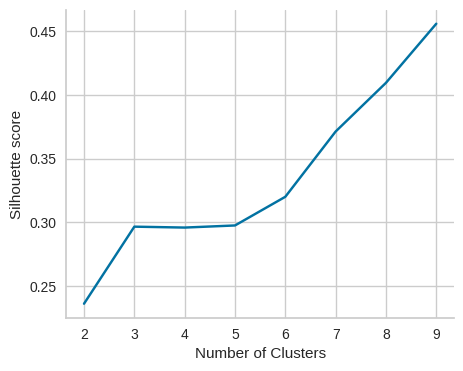

In [235]:
socio_demo_kmeans_sil = plot_silhouette_score(df_socio_demo_minmax, 10, KMeans)

In [236]:
kmeans_best_cluster = 6
km = KMeans(n_clusters = kmeans_best_cluster)
df_socio_demo[f'kmeans_{kmeans_best_cluster}'] = km.fit_predict(df_socio_demo_minmax)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [237]:
cat_socio_demo_mode = df_socio_demo.groupby(['kmeans_6'])[['EducDeg', 'Children']].agg(pd.Series.mode).T
num_socio_demo_median = df_socio_demo.groupby('kmeans_6')[list(set(df_socio_demo.columns) - set(['EducDeg', 'Children']))].median().T
pd.concat([cat_socio_demo_mode, num_socio_demo_median])

kmeans_6                                 0          1          2          3  \
EducDeg                           3.000000   3.000000   3.000000   3.000000   
Children                          1.000000   0.000000   1.000000   0.000000   
ClaimsRate                        0.730000   0.720000   0.730000   0.710000   
AnnualSal_binned_(24000, 36000]   1.000000   0.000000   0.000000   0.000000   
AnnualSal_binned_(48000, 60000]   0.000000   0.000000   0.000000   1.000000   
GeoLivArea_2.0                    0.000000   0.000000   0.000000   0.000000   
Commitment                       45.404646  58.654496  22.570039  71.507263   
AnnualSal_binned_(>60000]         0.000000   0.000000   0.000000   0.000000   
GeoLivArea_4.0                    0.000000   0.000000   1.000000   0.000000   
Age                              49.000000  65.000000  29.000000  74.000000   
AnnualSal_binned_(36000, 48000]   0.000000   1.000000   0.000000   0.000000   
GeoLivArea_1.0                    1.000000   0.000000   0.000000   0.000000   
AnnualSal_binned_(12000, 24000]   0.000000   0.000000   1.000000   0.000000   
kmeans_6                          0.000000   1.000000   2.000000   3.000000   
GeoLivArea_3.0                    0.000000   0.000000   0.000000   0.000000   

kmeans_6                                 4          5  
EducDeg                           3.000000   3.000000  
Children                          1.000000   1.000000  
ClaimsRate                        0.740000   0.710000  
AnnualSal_binned_(24000, 36000]   1.000000   0.000000  
AnnualSal_binned_(48000, 60000]   0.000000   0.000000  
GeoLivArea_2.0                    0.000000   0.000000  
Commitment                       44.624557  23.089341  
AnnualSal_binned_(>60000]         0.000000   0.000000  
GeoLivArea_4.0                    1.000000   0.000000  
Age                              48.000000  29.000000  
AnnualSal_binned_(36000, 48000]   0.000000   0.000000  
GeoLivArea_1.0                    0.000000   1.000000  
AnnualSal_binned_(12000, 24000]   0.000000   1.000000  
kmeans_6                          4.000000   5.000000  
GeoLivArea_3.0                    0.000000   0.000000

# Post Clustering EDA

In [273]:
df['claim_amount'] = df['Total_Premiums'] * df['ClaimsRate']
df['retention_cost'] = (df['Total_Premiums'] - df['claim_amount'])*(2016-df['FirstPolYear']) - df['CustMonVal']
df['Profit_percent'] = (df['Total_Premiums'] - df['claim_amount'])*100/ df['claim_amount']
df['Loss'] = np.where(df['Profit_percent']<0, True, False)

In [285]:
km = KMeans(n_clusters = 6)
df['kmeans_6'] = km.fit_predict(df_minmax)

pd.concat([
df.groupby('kmeans_6')[list(df_minmax.columns) +
                       ['retention_cost', 'Profit_percent']].median().T,
    df.groupby('kmeans_6').apply(lambda x: x[['Loss']].sum()*100/len(x)).T
])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


kmeans_6                                   0            1            2  \
FirstPolYear                     1986.000000  1995.000000  1986.000000   
EducDeg                             3.000000     2.000000     3.000000   
GeoLivArea                          3.000000     3.000000     3.000000   
Children                            1.000000     1.000000     1.000000   
CustMonVal                        207.830000   170.205000   178.360000   
ClaimsRate                          0.700000     0.780000     0.730000   
PremMotor                         359.290000    92.795000   394.740000   
PremHousehold                     108.900000   414.800000    78.900000   
PremHealth                        132.470000   177.755000   125.690000   
PremLife                           22.560000    85.850000    14.780000   
PremWork                           22.450000    83.240000    15.890000   
Age                                60.000000    22.000000    48.000000   
Total_Premiums                    685.120000   922.555000   657.000000   
Commitment                         58.624339     9.866308    45.062435   
AnnualSal_binned_(0, 12000]         0.000000     1.000000     0.000000   
AnnualSal_binned_(12000, 24000]     0.000000     0.000000     0.000000   
AnnualSal_binned_(24000, 36000]     0.000000     0.000000     1.000000   
AnnualSal_binned_(36000, 48000]     1.000000     0.000000     0.000000   
AnnualSal_binned_(48000, 60000]     0.000000     0.000000     0.000000   
AnnualSal_binned_(>60000]           0.000000     0.000000     0.000000   
retention_cost                   6237.230000  4015.306000  5429.583200   
Profit_percent                     42.857143    28.205128    36.986301   
Loss                               16.653193    19.190141    18.400741   

kmeans_6                                   3            4            5  
FirstPolYear                     1990.000000  1987.000000  1987.000000  
EducDeg                             3.000000     3.000000     3.000000  
GeoLivArea                          3.000000     3.000000     3.000000  
Children                            1.000000     0.000000     0.000000  
CustMonVal                        195.600000   182.930000   192.535000  
ClaimsRate                          0.710000     0.720000     0.710000  
PremMotor                         251.270000   243.380000   257.050000  
PremHousehold                     171.700000   160.600000   147.250000  
PremHealth                        181.700000   209.985000   209.930000  
PremLife                           31.450000    34.450000    28.340000  
PremWork                           34.450000    30.560000    30.560000  
Age                                31.000000    69.000000    74.000000  
Total_Premiums                    728.910000   721.360000   709.860000  
Commitment                         25.245978    58.665318    71.507263  
AnnualSal_binned_(0, 12000]         0.000000     0.000000     0.000000  
AnnualSal_binned_(12000, 24000]     1.000000     0.000000     0.000000  
AnnualSal_binned_(24000, 36000]     0.000000     0.000000     0.000000  
AnnualSal_binned_(36000, 48000]     0.000000     1.000000     0.000000  
AnnualSal_binned_(48000, 60000]     0.000000     0.000000     1.000000  
AnnualSal_binned_(>60000]           0.000000     0.000000     0.000000  
retention_cost                   5507.624400  5597.153400  5634.683750  
Profit_percent                     40.845070    38.888889    40.845070  
Loss                               16.590830    15.898058    15.719064

In [282]:
df['ac_6'] = ac_labels

In [286]:
pd.concat([
df.groupby('ac_6')[list(df_minmax.columns) +
                       ['retention_cost', 'Profit_percent']].median().T,
    df.groupby('ac_6').apply(lambda x: x[['Loss']].sum()*100/len(x)).T
])

ac_6                                       0            1            2  \
FirstPolYear                     1986.000000  1990.000000  1987.000000   
EducDeg                             3.000000     3.000000     3.000000   
GeoLivArea                          3.000000     3.000000     3.000000   
Children                            1.000000     1.000000     0.000000   
CustMonVal                        178.360000   195.600000   182.820000   
ClaimsRate                          0.730000     0.710000     0.720000   
PremMotor                         394.740000   251.270000   243.270000   
PremHousehold                      78.900000   171.700000   160.600000   
PremHealth                        125.690000   181.700000   210.040000   
PremLife                           14.780000    31.450000    34.450000   
PremWork                           15.890000    34.450000    30.560000   
Age                                48.000000    31.000000    69.000000   
Total_Premiums                    657.000000   728.910000   721.480000   
Commitment                         45.062435    25.245978    58.668449   
AnnualSal_binned_(0, 12000]         0.000000     0.000000     0.000000   
AnnualSal_binned_(12000, 24000]     0.000000     1.000000     0.000000   
AnnualSal_binned_(24000, 36000]     1.000000     0.000000     0.000000   
AnnualSal_binned_(36000, 48000]     0.000000     0.000000     1.000000   
AnnualSal_binned_(48000, 60000]     0.000000     0.000000     0.000000   
AnnualSal_binned_(>60000]           0.000000     0.000000     0.000000   
retention_cost                   5429.583200  5507.624400  5589.780400   
Profit_percent                     36.986301    40.845070    38.888889   
Loss                               18.400741    16.590830    15.888417   

ac_6                                       3            4            5  
FirstPolYear                     1995.000000  1987.000000  1986.000000  
EducDeg                             2.000000     3.000000     3.000000  
GeoLivArea                          3.000000     3.000000     3.000000  
Children                            1.000000     0.000000     1.000000  
CustMonVal                        170.205000   193.040000   207.830000  
ClaimsRate                          0.780000     0.710000     0.700000  
PremMotor                          92.795000   257.050000   359.290000  
PremHousehold                     414.800000   147.250000   108.900000  
PremHealth                        177.755000   209.930000   132.470000  
PremLife                           85.850000    28.340000    22.560000  
PremWork                           83.240000    30.560000    22.450000  
Age                                22.000000    74.000000    60.000000  
Total_Premiums                    922.555000   709.240000   685.120000  
Commitment                          9.866308    71.494580    58.624339  
AnnualSal_binned_(0, 12000]         1.000000     0.000000     0.000000  
AnnualSal_binned_(12000, 24000]     0.000000     0.000000     0.000000  
AnnualSal_binned_(24000, 36000]     0.000000     0.000000     0.000000  
AnnualSal_binned_(36000, 48000]     0.000000     0.000000     1.000000  
AnnualSal_binned_(48000, 60000]     0.000000     1.000000     0.000000  
AnnualSal_binned_(>60000]           0.000000     0.000000     0.000000  
retention_cost                   4015.306000  5701.090000  6237.230000  
Profit_percent                     28.205128    40.845070    42.857143  
Loss                               19.190141    15.745394    16.653193

Similar clusters are obtained with different clustering methods.

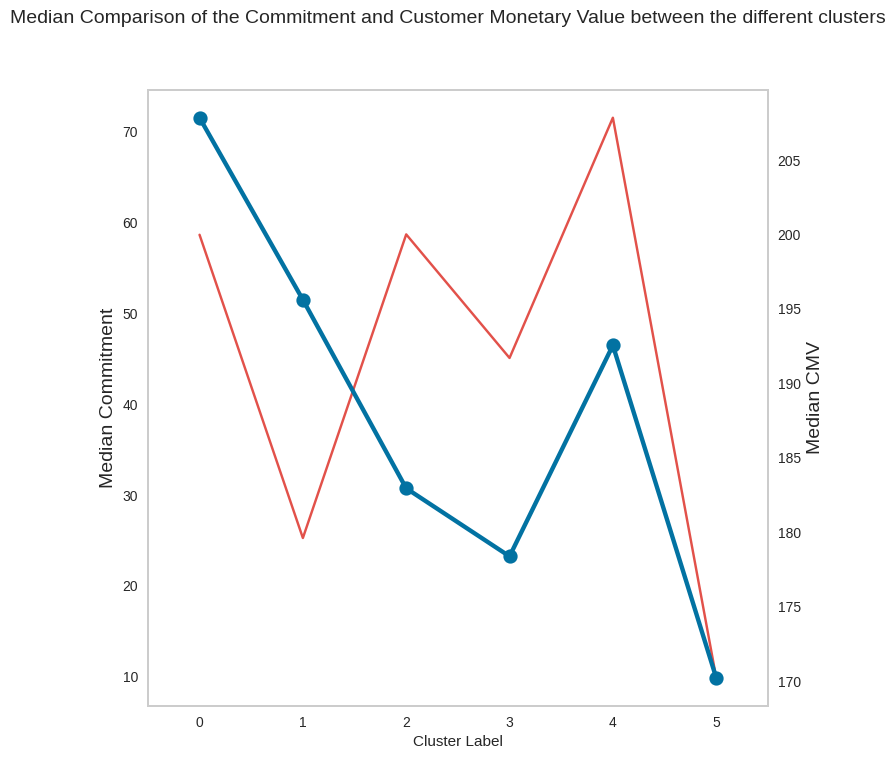

In [152]:
fig, ax1 = plt.subplots(figsize=(8, 8))

colors = sns.color_palette('Spectral')
sns.lineplot(df.groupby('kmeans_6')['Commitment'].median().reset_index(), x='kmeans_6', y='Commitment', color=colors[0], ax=ax1)

ax2 = ax1.twinx()

gc = df.groupby('kmeans_6')['CustMonVal'].median().reset_index()
sns.pointplot(data=gc, x='kmeans_6', y='CustMonVal', ax=ax2)


ax1.set_xlabel("Cluster Label")
ax1.set_ylabel("Median Commitment", fontsize=14)
ax1.tick_params(axis="y")
ax1.grid(False)

ax2.set_ylabel("Median CMV", fontsize=14)
ax2.tick_params(axis="y",)
ax2.grid(False)

fig.suptitle("Median Comparison of the Commitment and Customer Monetary Value between the different clusters", fontsize=14)

plt.show();

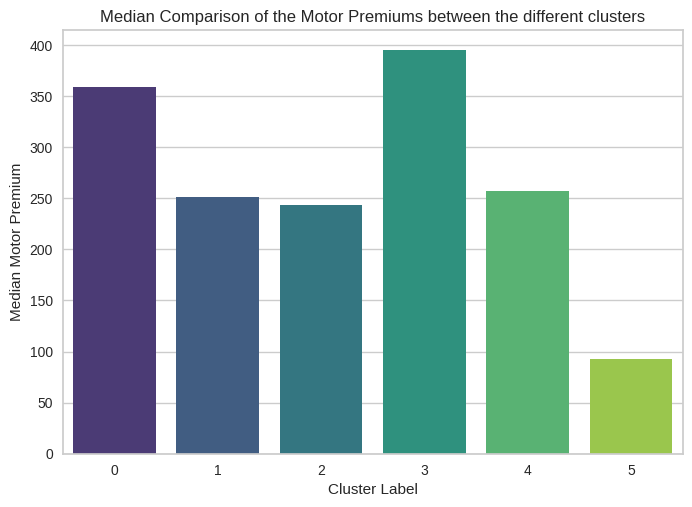

In [121]:
colors = sns.color_palette('viridis')
sns.barplot(df.groupby('kmeans_6')['PremMotor'].median().reset_index(), x = 'kmeans_6', y = 'PremMotor', palette = colors, hue = 'kmeans_6', legend = False)
plt.title('Median Comparison of the Motor Premiums between the different clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Median Motor Premium')
plt.show()

<ipython-input-122-b663f8d406f6>:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(df.groupby('kmeans_6')['PremHealth'].median().reset_index(), x = 'kmeans_6', y = 'PremHealth', palette = colors, hue = 'kmeans_6', legend = False)


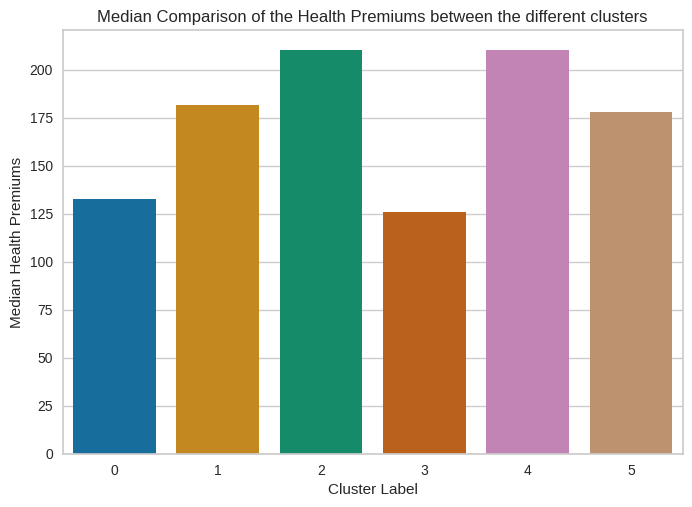

In [122]:
colors = sns.color_palette('colorblind')
sns.barplot(df.groupby('kmeans_6')['PremHealth'].median().reset_index(), x = 'kmeans_6', y = 'PremHealth', palette = colors, hue = 'kmeans_6', legend = False)
plt.title('Median Comparison of the Health Premiums between the different clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Median Health Premiums')
plt.show()

<ipython-input-130-eb11a33e99e8>:2: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.barplot(df.groupby('kmeans_6')['PremHousehold'].median().reset_index(), x = 'kmeans_6', y = 'PremHousehold', palette = colors, hue = 'kmeans_6', legend = False)


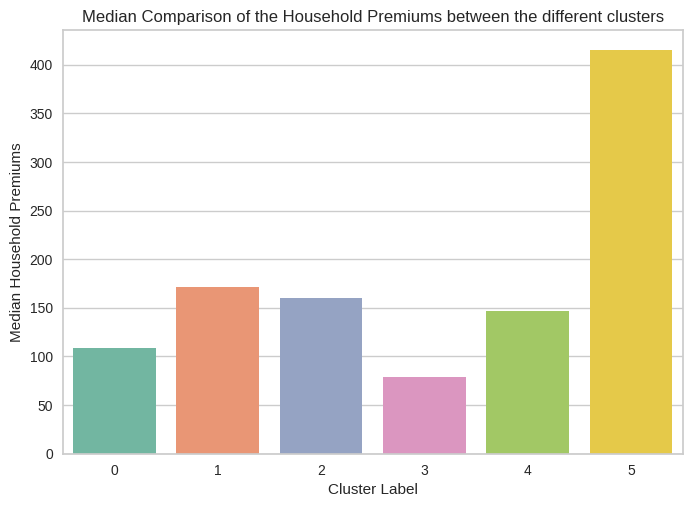

In [130]:
colors = sns.color_palette('Set2')
sns.barplot(df.groupby('kmeans_6')['PremHousehold'].median().reset_index(), x = 'kmeans_6', y = 'PremHousehold', palette = colors, hue = 'kmeans_6', legend = False)
plt.title('Median Comparison of the Household Premiums between the different clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Median Household Premiums')
plt.show();

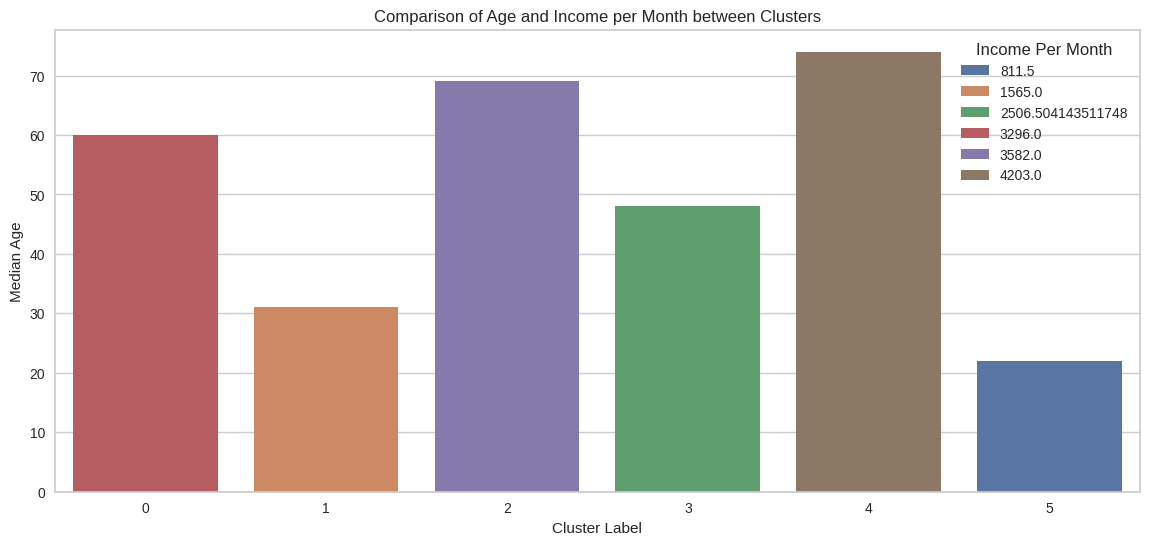

In [133]:
ai_df = df.groupby('kmeans_6')[['Age', 'MonthSal']].median().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(data=ai_df, x='kmeans_6', y='Age', hue='MonthSal', palette='deep')
plt.title('Comparison of Age and Income per Month between Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Median Age')
plt.legend(title='Income Per Month')
plt.show()

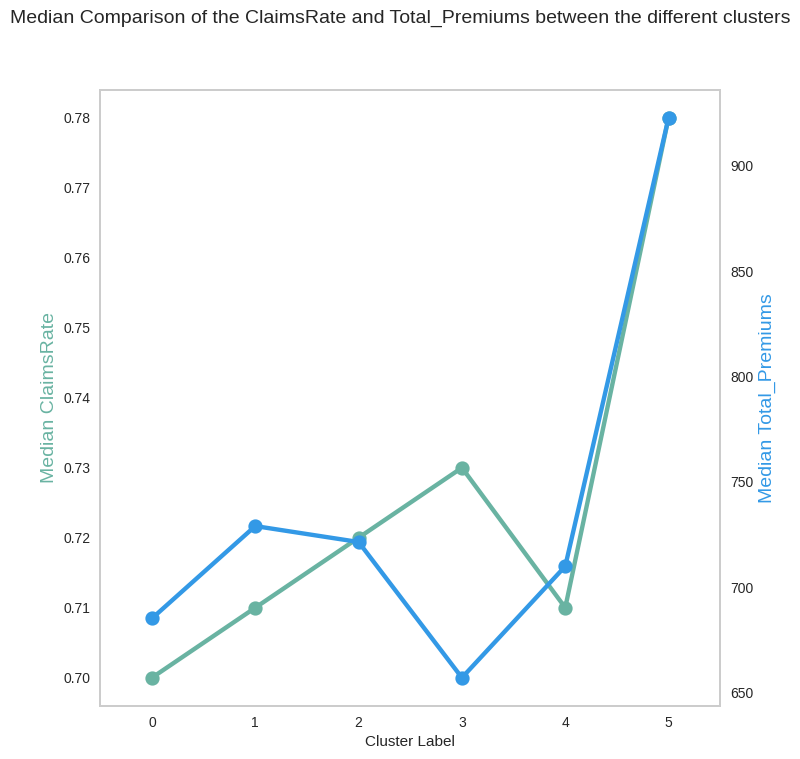

In [168]:
COLOR_1 = "#69b3a2"
COLOR_2 = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))


gc = df.groupby('kmeans_6')['ClaimsRate'].median().reset_index()

sns.pointplot(data=gc, x='kmeans_6', y='ClaimsRate', ax=ax1, color=COLOR_1)

ax2 = ax1.twinx()

gc = df.groupby('kmeans_6')['Total_Premiums'].median().reset_index()
sns.pointplot(data=gc, x='kmeans_6', y='Total_Premiums', ax=ax2, color=COLOR_2)


ax1.set_xlabel("Cluster Label", )
ax1.set_ylabel("Median ClaimsRate", fontsize=14, color=COLOR_1)
ax1.tick_params(axis="y")
ax1.grid(False)

ax2.set_ylabel("Median Total_Premiums", fontsize=14, color=COLOR_2)
ax2.tick_params(axis="y",)
ax2.grid(False)

fig.suptitle("Median Comparison of the ClaimsRate and Total_Premiums between the different clusters", fontsize=14)

plt.show();

In [127]:
ac = df.groupby('kmeans_6')[['Commitment', 'Age']].median().reset_index()

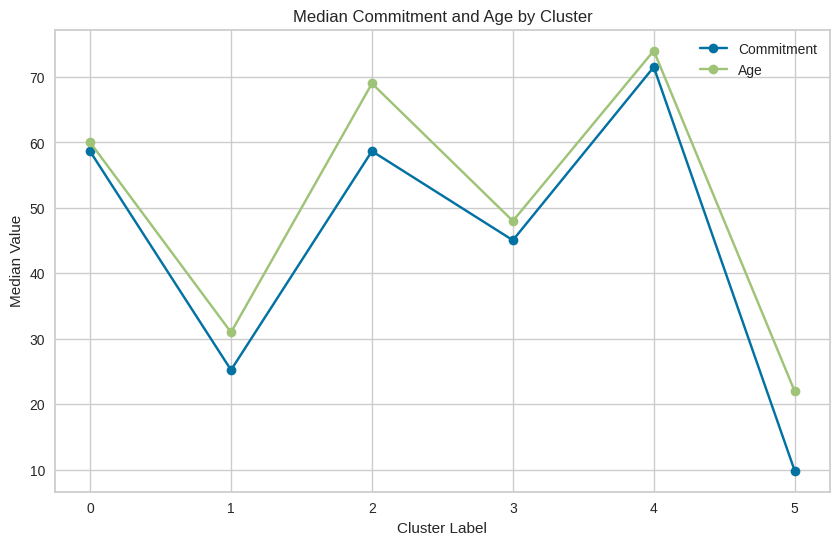

In [128]:
fig, ax = plt.subplots(figsize=(10, 6))
for column in ['Commitment', 'Age']:
    ax.plot(ac['kmeans_6'], ac[column], marker='o', label=column)
ax.set_title('Median Commitment and Age by Cluster')
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Median Value')

ax.legend()
plt.show()

In [178]:
df.columns

Index(['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment', 'AnnualSal_binned_(0, 12000]',
       'AnnualSal_binned_(12000, 24000]', 'AnnualSal_binned_(24000, 36000]',
       'AnnualSal_binned_(36000, 48000]', 'AnnualSal_binned_(48000, 60000]',
       'AnnualSal_binned_(>60000]', 'kmeans_6', 'claim_amount',
       'retention_cost', 'Profit_percent', 'Loss'],
      dtype='object')

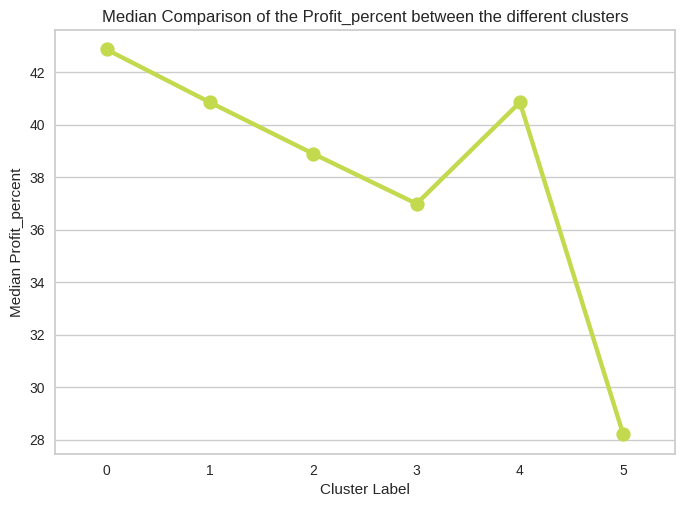

In [190]:
colors = sns.color_palette('Set2')

gc = df.groupby('kmeans_6')['Profit_percent'].median().reset_index()
sns.pointplot(data=gc, x='kmeans_6', y='Profit_percent', color = "#c3d94e")
plt.title('Median Comparison of the Profit_percent between the different clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Median Profit_percent')
plt.show();

In [ ]:
COLOR_1 = "#69b3a2"
COLOR_2 = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))


gc = df.groupby('kmeans_6')['ClaimsRate'].median().reset_index()

sns.pointplot(data=gc, x='kmeans_6', y='ClaimsRate', ax=ax1, color=COLOR_1)

ax2 = ax1.twinx()

gc = df.groupby('kmeans_6')['Total_Premiums'].median().reset_index()
sns.pointplot(data=gc, x='kmeans_6', y='Total_Premiums', ax=ax2, color=COLOR_2)


ax1.set_xlabel("Cluster Label", )
ax1.set_ylabel("Median ClaimsRate", fontsize=14, color=COLOR_1)
ax1.tick_params(axis="y")
ax1.grid(False)

ax2.set_ylabel("Median Total_Premiums", fontsize=14, color=COLOR_2)
ax2.tick_params(axis="y",)
ax2.grid(False)

fig.suptitle("Median Comparison of the ClaimsRate and Total_Premiums between the different clusters", fontsize=14)

plt.show();

In [171]:
def outlier_visualization(data: pd.DataFrame, cols: list, plot: str):
    num_cols = len(cols)
    num_rows = math.ceil(math.sqrt(num_cols))
    num_cols_per_row = math.ceil(num_cols / num_rows)

    figure, ax = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 10))
    ax = ax.flatten()

    for i, v in enumerate(cols):
        if plot == 'boxplot':
            sns.boxplot(data[v], ax=ax[i])
            ax[i].set_xlabel(v)
        elif plot == 'violinplot':
            sns.violinplot(data[v], ax=ax[i])
            ax[i].set_xlabel(v)

    for j in range(num_cols, num_rows * num_cols_per_row):
        figure.delaxes(ax[j])

    plt.tight_layout()
    plt.show()



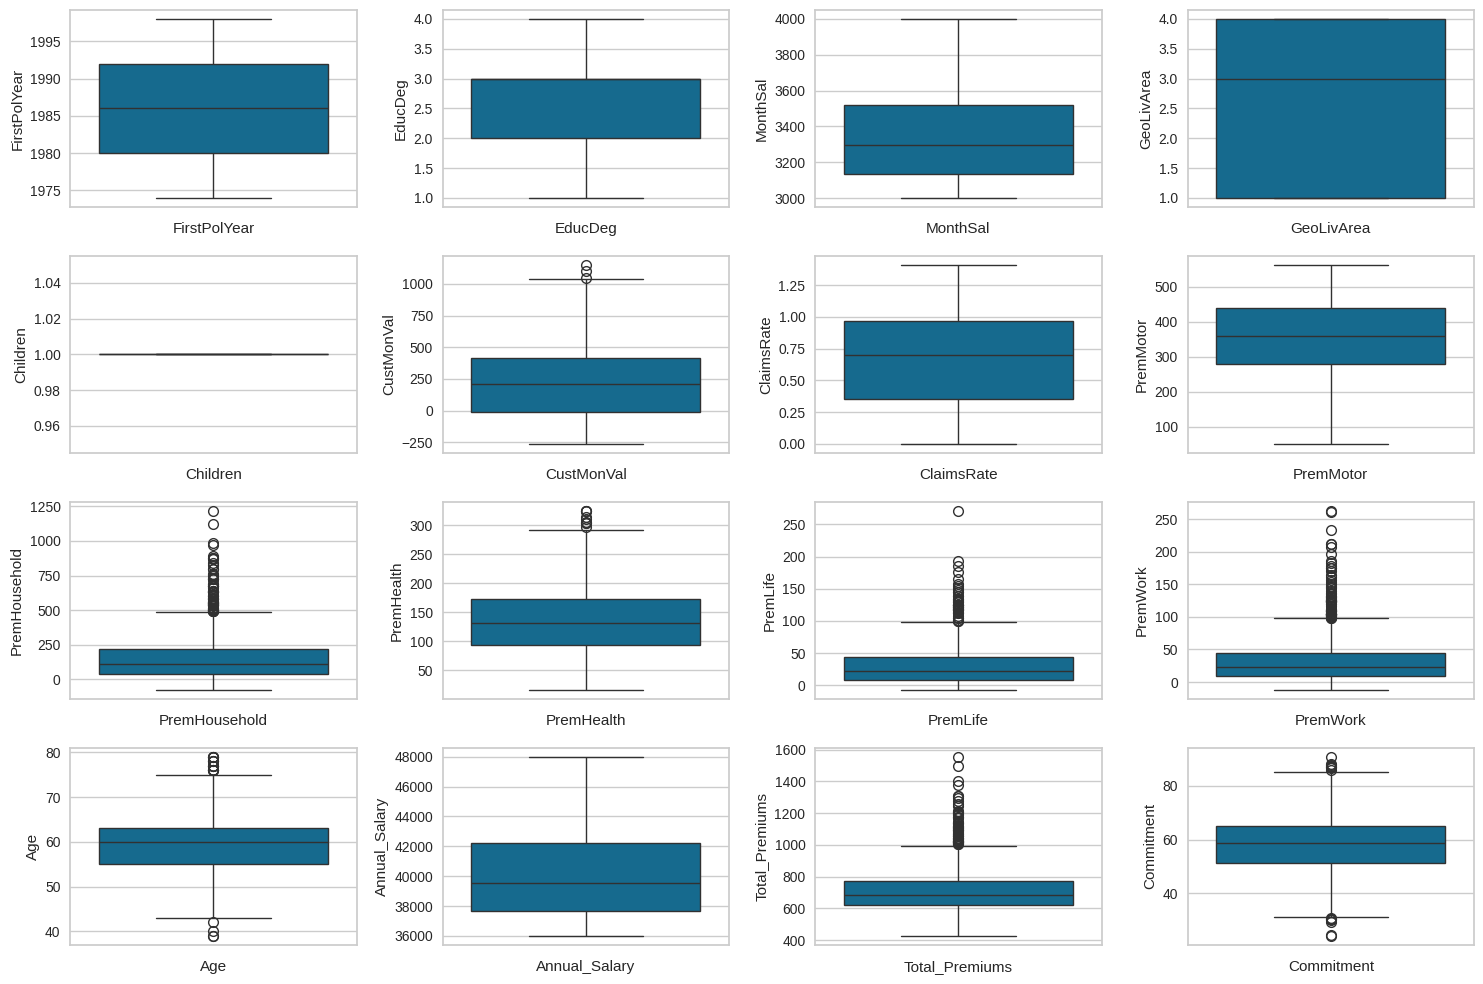

In [172]:
cluster0 = df.loc[df['kmeans_6'] == 0]
outlier_visualization(cluster0, ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment'], 'boxplot')

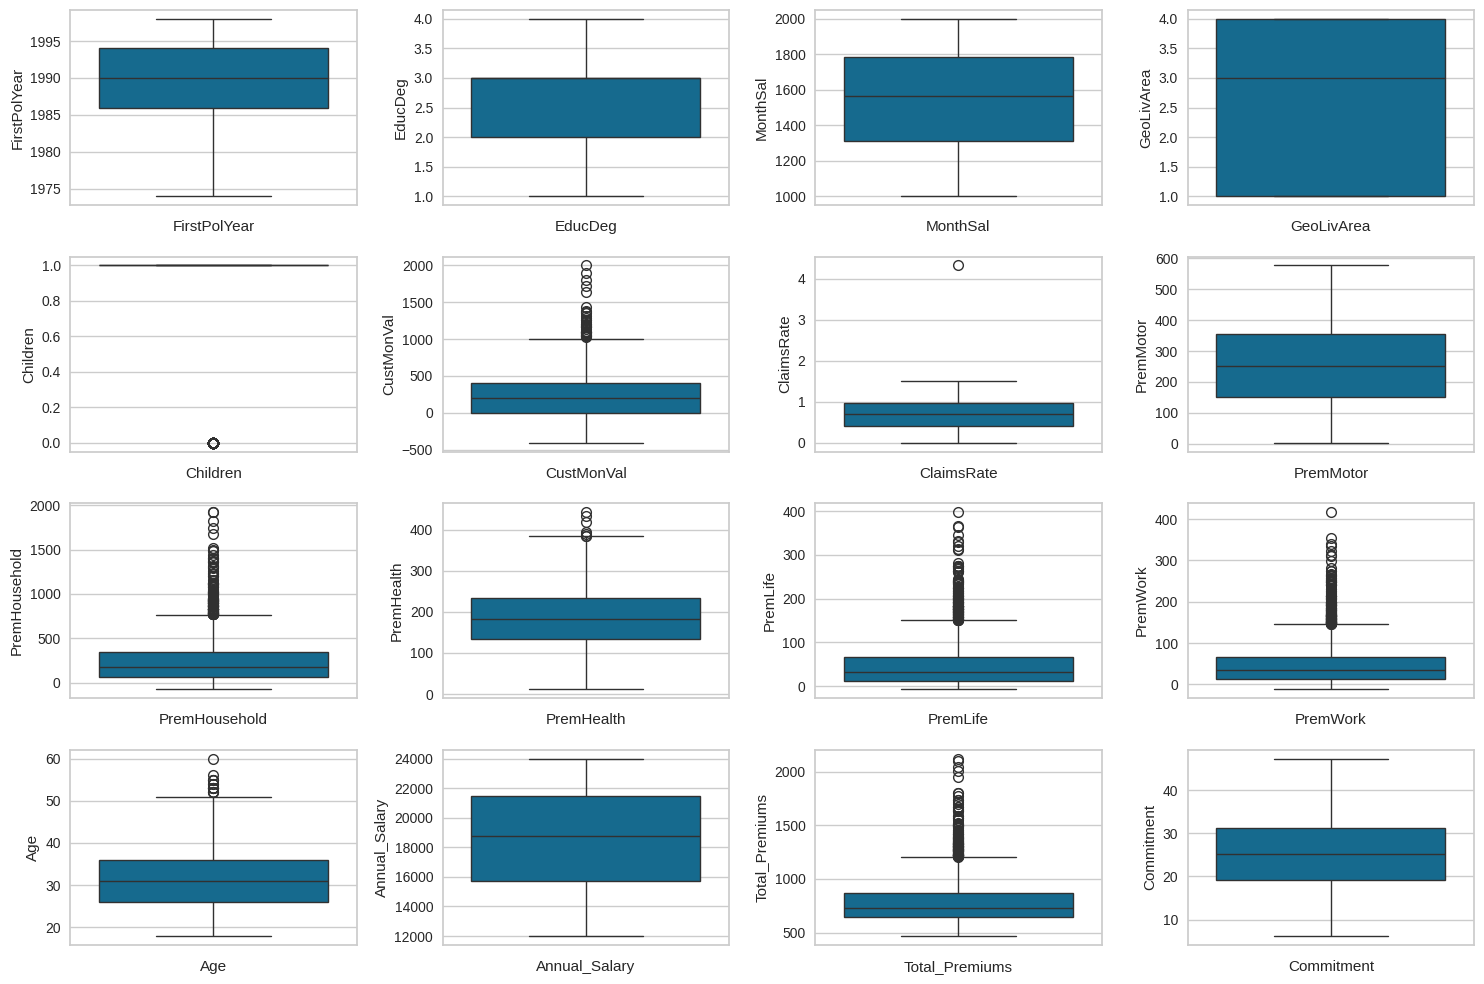

In [173]:
cluster1 = df.loc[df['kmeans_6'] == 1]
outlier_visualization(cluster1, ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment'], 'boxplot')

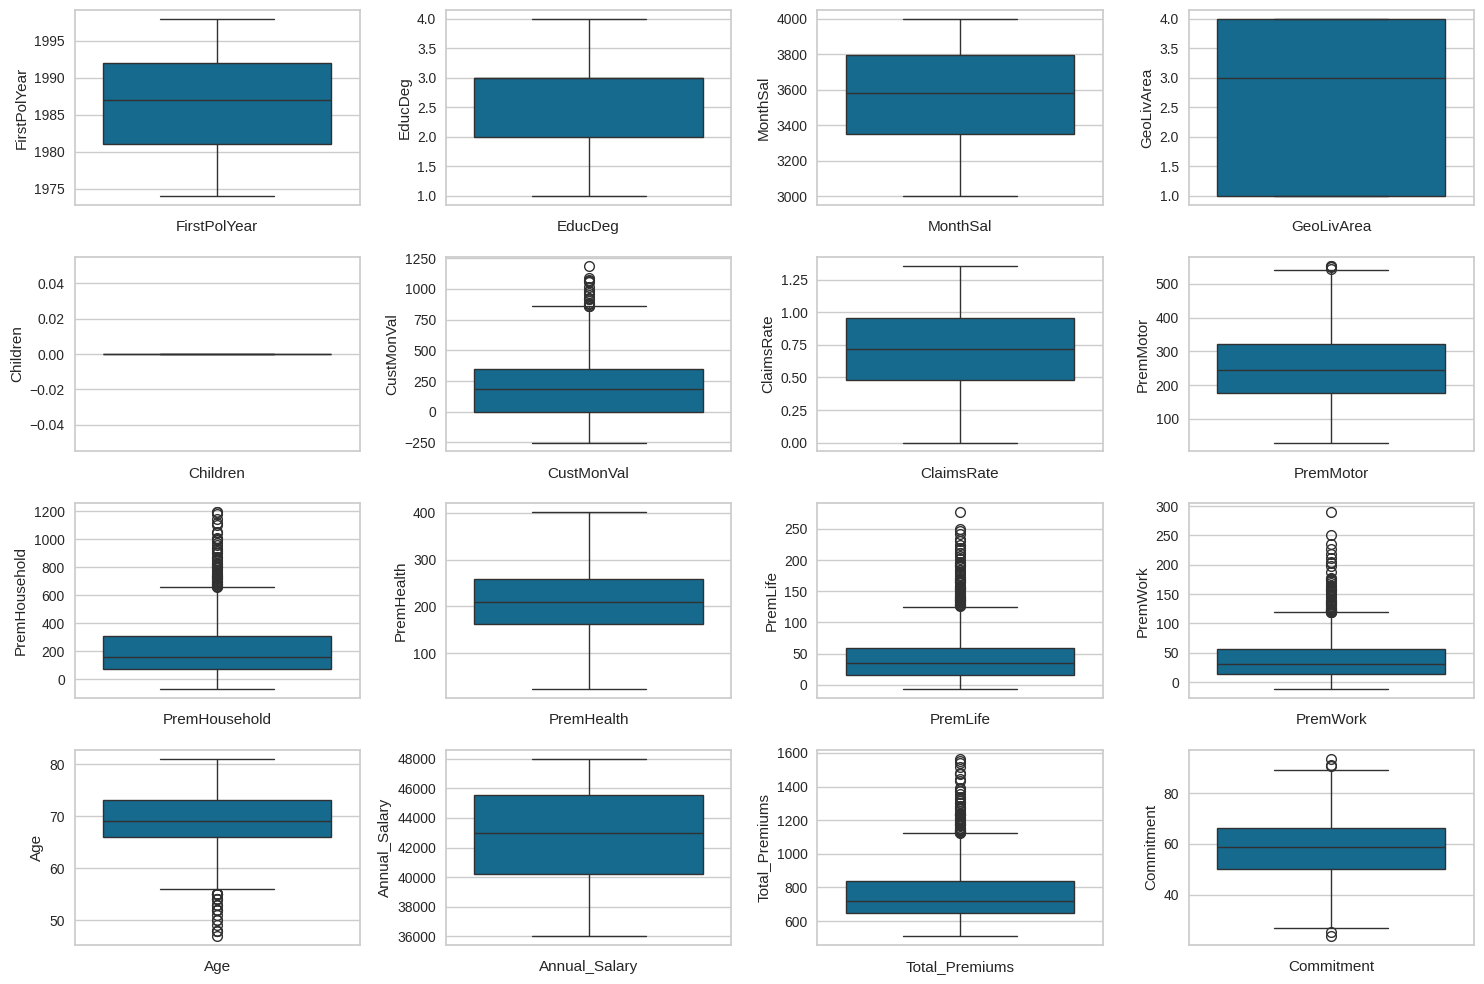

In [174]:
cluster2 = df.loc[df['kmeans_6'] == 2]
outlier_visualization(cluster2, ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment'], 'boxplot')

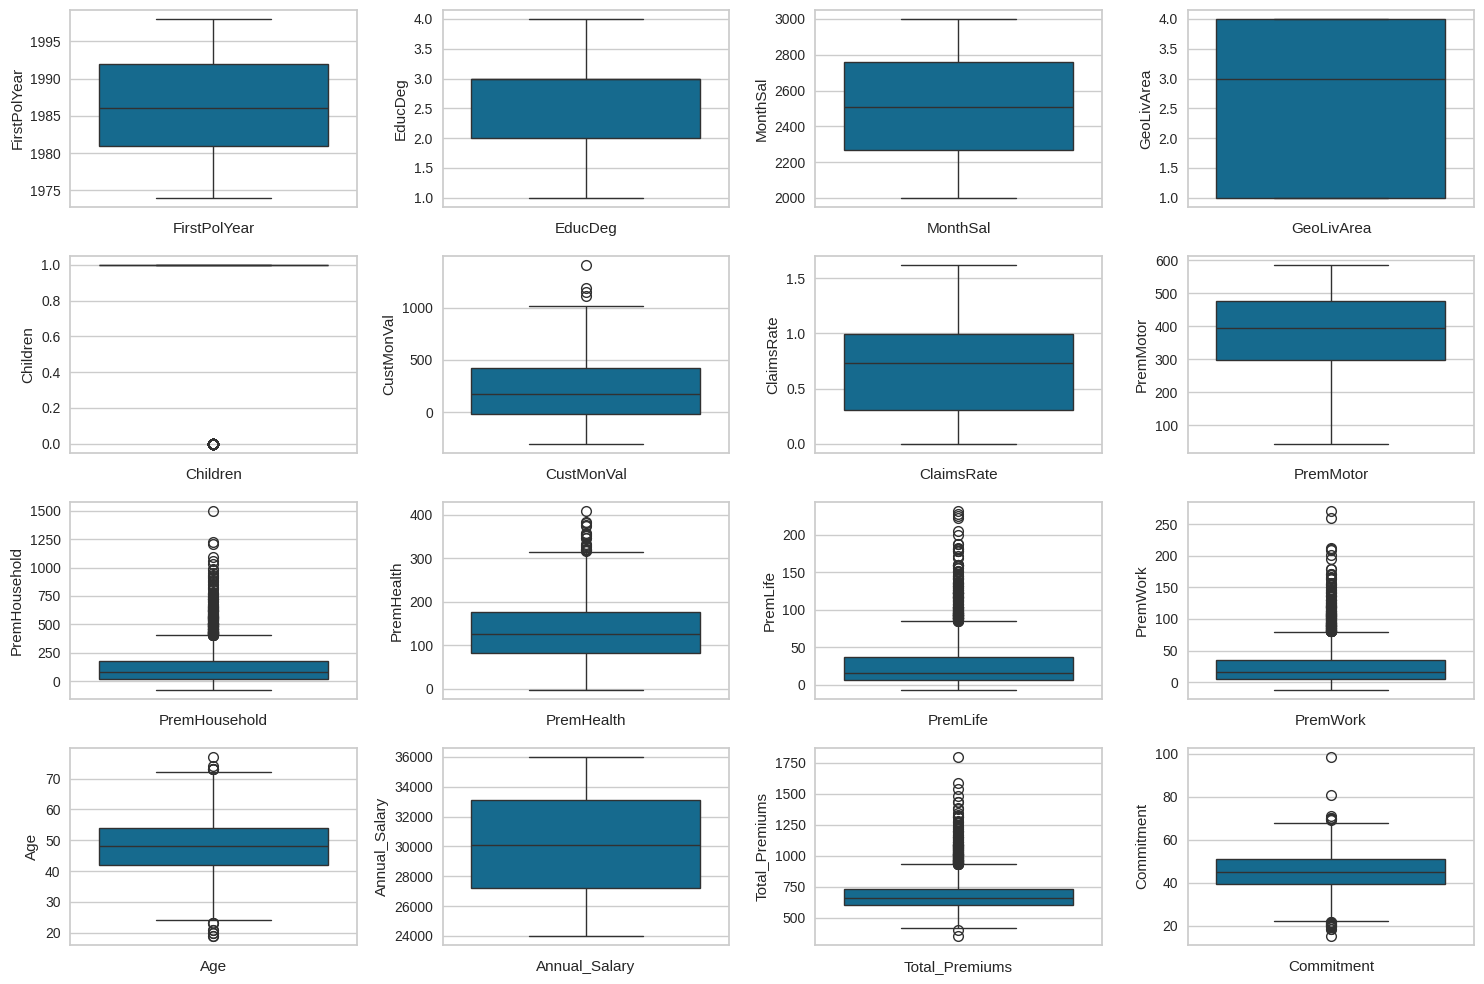

In [175]:
cluster3 = df.loc[df['kmeans_6'] == 3]
outlier_visualization(cluster3, ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment'], 'boxplot')

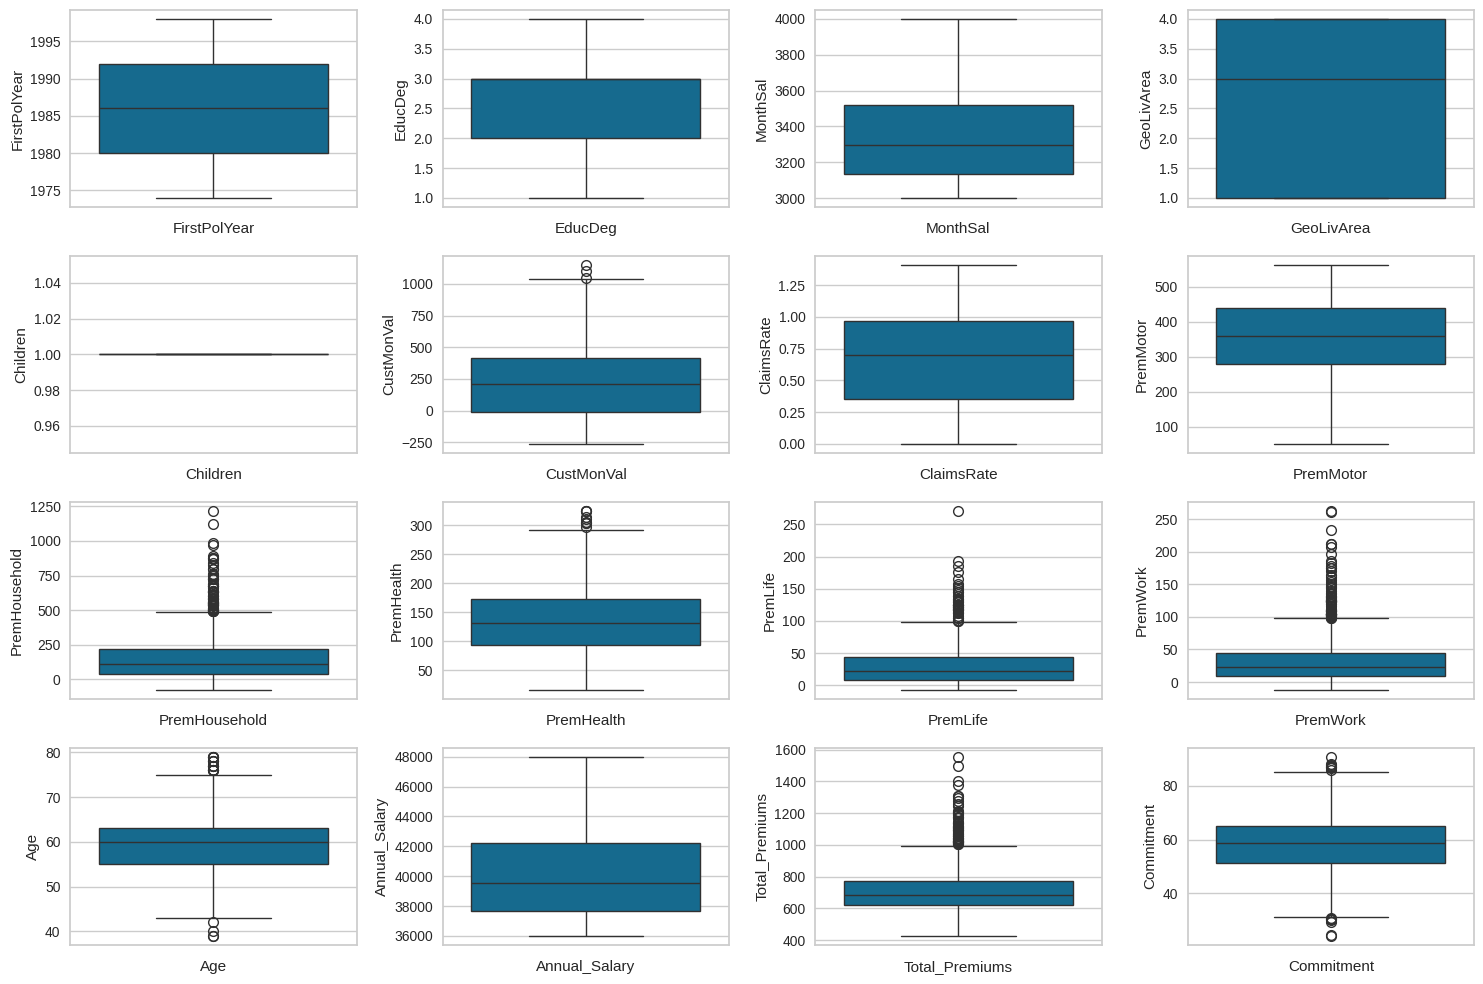

In [176]:
cluster4 = df.loc[df['kmeans_6'] == 4]
outlier_visualization(cluster0, ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment'], 'boxplot')

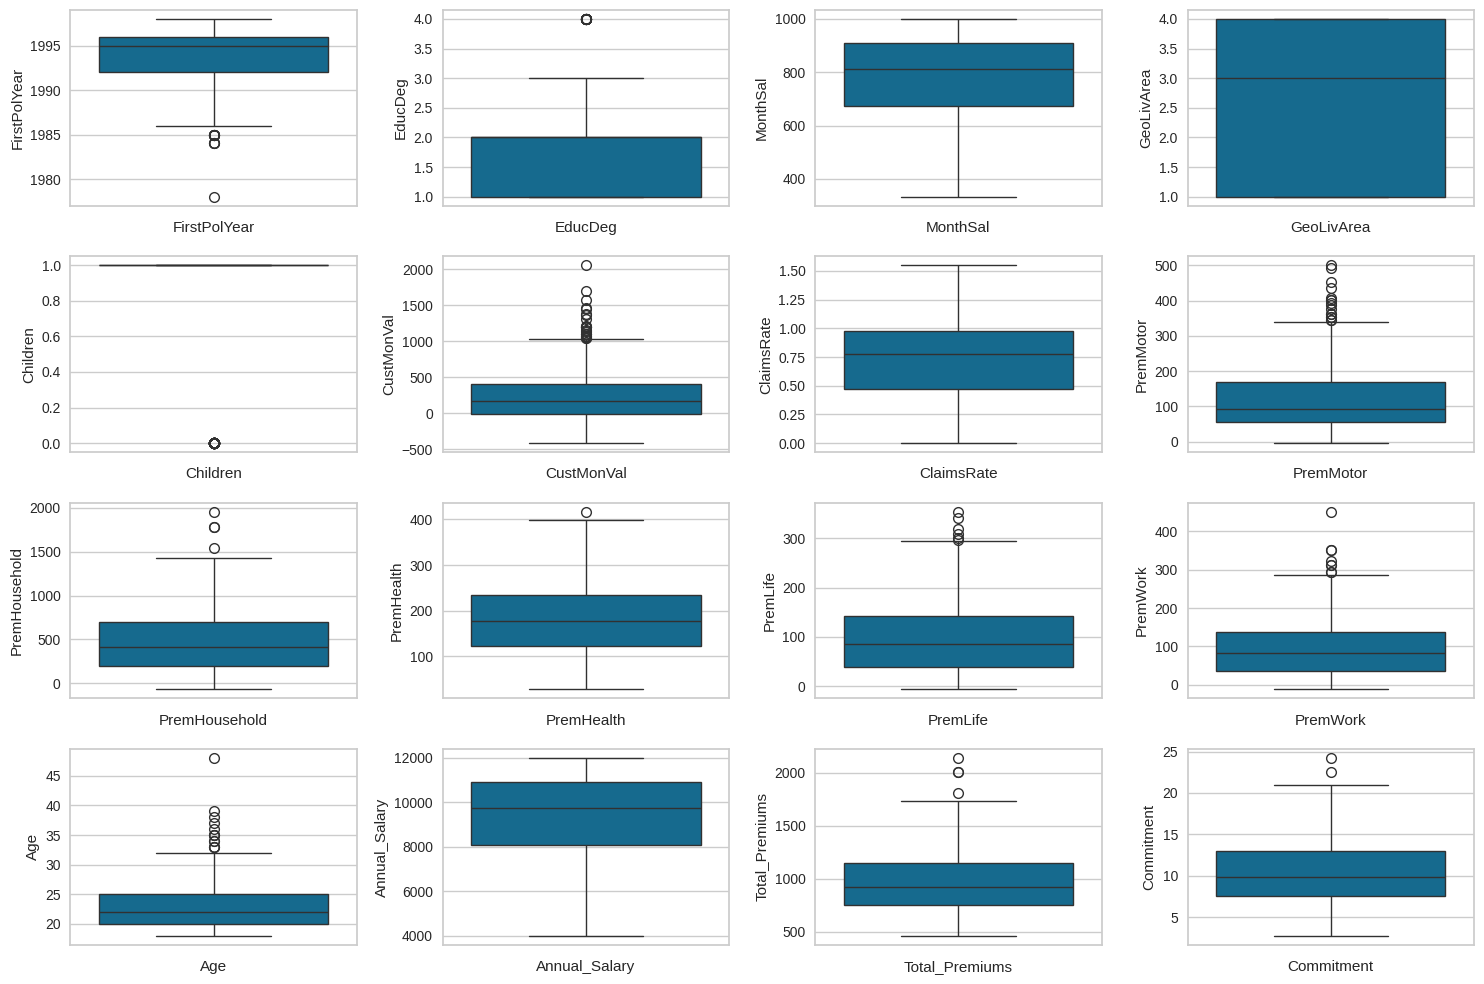

In [177]:
cluster5 = df.loc[df['kmeans_6'] == 5]
outlier_visualization(cluster5, ['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Age', 'Annual_Salary', 'Total_Premiums',
       'Commitment'], 'boxplot')

# Insights

 - Commitment increases with age.
 - Working professionals have highest motor premiums.
 - Company should focus more on household premiums as it contsitutes a major percent of total premiums.
 - Teens and Young adults contribute the most premiums overall and in most types of premiums

1. Profitable Customers, in their middle age with lowest claim rate
* Middle-class salary between 3000 and 4000 euros
* Most of have children and are educated
* Largest Retention Cost
* Second highest Motor premiums although presenting the lowest claims rate
* Second Lowest Health premiums. \

2. Educated young adults with low purchasing power
* Young adults, born around 1985
* Educated people
* Monthly salary between 1000 and 2000 euros
* Contribute high premiums along with low retention cost
* Overall a secure client. \

3. Senior people with no children and high purchasing power
* All customers have a monthly income between 3000 and 4000 euros
* Educated people (Bachelor/ Masters degree)
* No children
* Senior people, on average 69 years
* Low percentage of claims rate
* Focuses more on health premium. \

4. Oldest customers with no children and high purchasing power
* Highest purchasing power with a monthly income above 4000 euros
* Educated people
* Most have no children
* Highest health premium
* High Commitment required
* Lowest loss percent \

5. Middle-aged customers with medium purchasing power
* Monthly Salaries between 2000 and 3000 euros
* Educated people
* Most have, at least, 1 child
* On Average 48 years old.
* Pays the highest Premiums for Motor.
* Pays less for Life, Work and Health premiums. \

6. Young adults with low purchasing power
* Most have a max income of 1000 euros
* They are less educated (most with only basic education)
* Most have, at least, 1 child
* Young adults, most being around 22 years old
* High Claim Rate with Low Retention Cost
* Contribute very Low to Motor Premiums but very High to other premiums.
* Highest house premiums but with lowest the profit percent and highest loss percent.